# Dự đoán giá xe ô tô cũ
Tiếp tục với phần trình bày trước, lần này ta sẽ thực hiện nghiên cứu và đánh giá các mô hình phân cụm tối ưu để áp dụng cho đề tài phân cụm ô tô cũ. Các bước tiến hành gồm:
+ Sử dụng, cải tiến các dữ liệu và tiền xử lý ở phần trước
+ Import và sử dụng các mô hình: ở đây sử dụng 2 mô hình K-means và GMM (Gaussian Mixture Model)
+ Hiệu chỉnh mô hình và trực quan hóa kết quả
+ Nhận xét

#### Import các thư viện cần thiết

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
import time
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder


#### Đọc dữ liệu từ file data train đã clean trước đó

In [13]:
data = pd.read_csv('clean_data_train.csv')
data.head(3)

Năm sản xuất  Tình trạng Kiểu dáng   Số Km đã đi    Xuất xứ        Hãng xe  \
0          2022  Xe đã dùng       SUV  30000.000000  Nhập khẩu           Ford   
1          2024      Xe mới       SUV      0.000000  Nhập khẩu  Mercedes Benz   
2          2007  Xe đã dùng     Sedan  78171.918485  Nhập khẩu         Toyota   

                   Dẫn động  Số chỗ ngồi   Địa điểm      Động cơ      Hộp số  \
0    RFD - Dẫn động cầu sau            7     Hà Nội   Dầu  2.0 L  Số tự động   
1    RFD - Dẫn động cầu sau            7     Hà Nội  Xăng  1.3 L  Số tự động   
2  FWD - Dẫn động cầu trước            5  Thanh Hóa  Xăng  2.4 L  Số tự động   

      Giá  
0  1050.0  
1  2089.0  
2   295.0

#### Chuẩn hóa và mã hóa dữ liệu
Vì khoảng cách giữa các giá trị trong từng đặt trưng và với các đặc trưng khác ảnh hưởng đến kết quả của 1 số mô hình phân cụm như K-means nên lựa chọn: 
- Cột Số Km đã đi chuẩn hóa bằng Robust Scaling
- Cột Hãng xe, Động cơ, Dẫn động, Địa điểm, Kiểu dáng, Xuất xứ, Tình trạng, Hộp số mã hóa bằng label encoder
- Các cột còn lại không cần mã hóa

In [15]:
robust_scaler = RobustScaler()
data['Số Km đã đi'] = robust_scaler.fit_transform(data[['Số Km đã đi']])
data['Giá'] = robust_scaler.fit_transform(data[['Giá']])

label_encoder = LabelEncoder()
data['Hãng xe'] = label_encoder.fit_transform(data['Hãng xe'])
data['Động cơ'] = label_encoder.fit_transform(data['Động cơ'])
data['Dẫn động'] = label_encoder.fit_transform(data['Dẫn động'])
data['Địa điểm'] = label_encoder.fit_transform(data['Địa điểm'])
data['Kiểu dáng'] = label_encoder.fit_transform(data['Kiểu dáng'])

data['Xuất xứ'] = label_encoder.fit_transform(data['Xuất xứ'])
data['Tình trạng'] = label_encoder.fit_transform(data['Tình trạng'])
data['Hộp số'] = label_encoder.fit_transform(data['Hộp số'])

data.to_csv('helpper/data_encoded.csv', index=False)
data.head(5)

Năm sản xuất  Tình trạng  Kiểu dáng  Số Km đã đi  Xuất xứ  Hãng xe  \
0          2022           1          5    -0.134459        1       18   
1          2024           0          5    -0.537837        1       46   
2          2007           1          6     0.513257        1       69   
3          2024           0          5    -0.537837        1       46   
4          2023           0          5    -0.537837        1       64   

   Dẫn động  Số chỗ ngồi  Địa điểm  Động cơ  Hộp số       Giá  
0         3            7        17        5       1  0.569986  
1         3            7        17       45       1  2.069264  
2         2            5        46       53       1 -0.519481  
3         1            7        17       59       1  6.096681  
4         2            7        45       28       0 -0.297258

#### Giảm chiều dữ liệu 
Để trực quan hóa và nhìn nhận tính chất phân cụm của dữ liệu. Ta lần lượt kiểm tra 2 phương pháp: PCA và t-sne để lựa chọn phương pháp tối ưu để giảm chiều dữ liệu

- Thực hiện chuẩn hóa dữ liệu bằng standard scaler phục vụ mục đích so sánh 2 phương pháp

In [6]:
scaler = StandardScaler()
standard_data = scaler.fit_transform(data)
standard_data = pd.DataFrame(standard_data, columns=data.columns)
standard_data.head()

Năm sản xuất  Tình trạng  Kiểu dáng  Số Km đã đi   Xuất xứ   Hãng xe  \
0      0.633744    0.539324   0.081794    -0.343197  1.143653 -1.195892   
1      1.017146   -1.854172   0.081794    -0.909517  1.143653  0.228427   
2     -2.241765    0.539324   0.665304     0.566159  1.143653  1.398404   
3      1.017146   -1.854172   0.081794    -0.909517  1.143653  0.228427   
4      0.825445   -1.854172   0.081794    -0.909517  1.143653  1.144061   

   Dẫn động  Số chỗ ngồi  Địa điểm   Động cơ    Hộp số       Giá    Cụm số  
0  1.320057     0.807093 -0.646670 -2.150264  0.415169 -0.032512  2.058641  
1  1.320057     0.807093 -0.646670  0.076743  0.415169  0.755403 -0.642420  
2  0.107618    -0.383471  1.304479  0.522144  0.415169 -0.605059  0.708110  
3 -1.104820     0.807093 -0.646670  0.856195  0.415169  2.871931 -0.642420  
4  0.107618     0.807093  1.237198 -0.869735 -2.408659 -0.488275 -0.642420

Ta tiến hành so sánh trên 2 phương diện
- Đo thời gian thực thi của việc giảm chiều dữ liệu từ 12 đặc trưng về 2 đặc trưng đối với cả 2 phương pháp
- So sánh sự biến đổi của cấu trúc, phân bố khi có sự biến động trên tập gốc

Thời gian thực thi của PCA: 0.033 giây
Thời gian thực thi của t-SNE: 670.072 giây


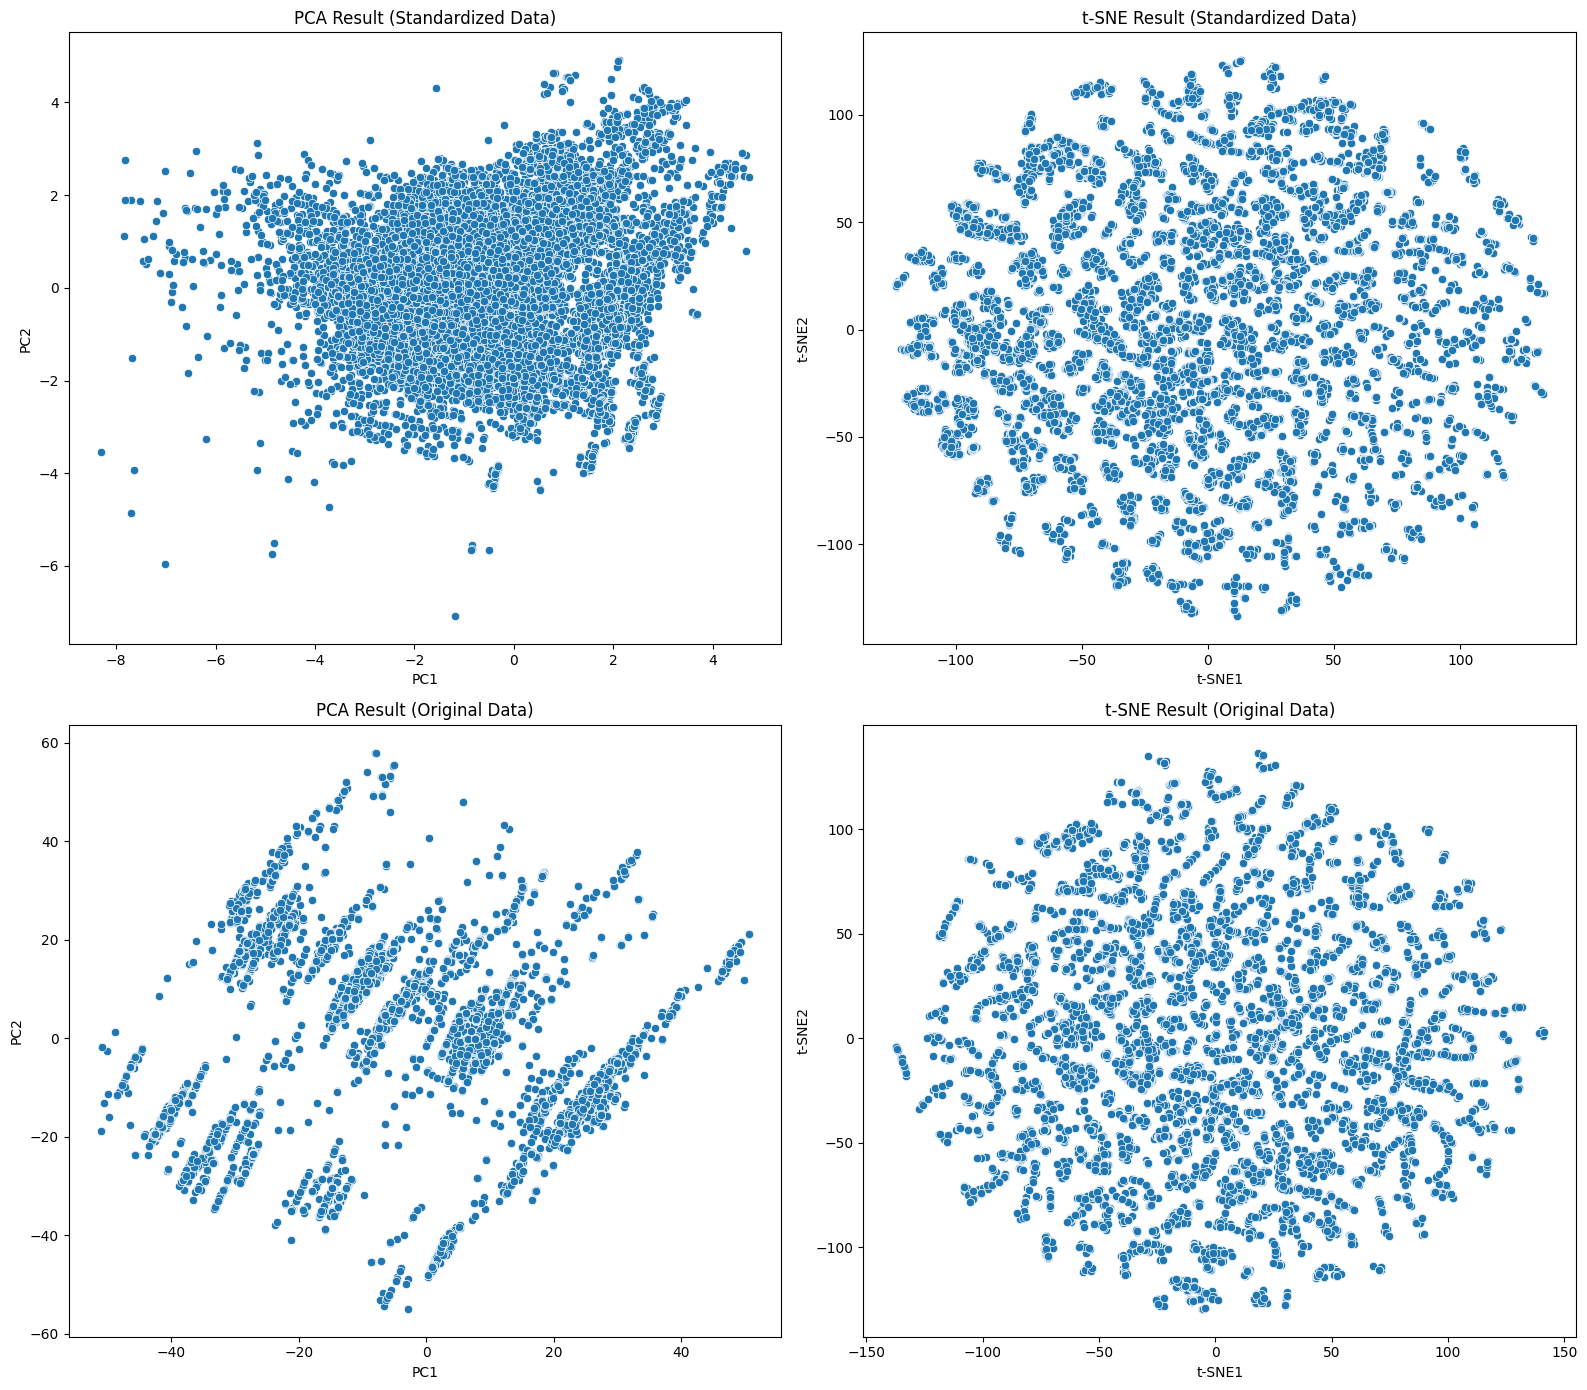

In [113]:
# Đo thời gian thực thi của PCA 
start_time_pca = time.time()
pca = PCA(n_components=2)
reduced_standard_pca = pca.fit_transform(standard_data)
reduced_df_pca = pca.fit_transform(data)
end_time_pca = time.time()
execution_time_pca = round(end_time_pca - start_time_pca, 3)

# Đo thời gian thực thi của t-SNE 
start_time_tsne = time.time()
tsne = TSNE(n_components=2, random_state=42)
reduced_standard_tsne = tsne.fit_transform(standard_data)
reduced_tsne = tsne.fit_transform(data)
end_time_tsne = time.time()
execution_time_tsne = round(end_time_tsne - start_time_tsne, 3)

# Chuyển đổi mảng numpy trở lại DataFrame
reduced_df_pca = pd.DataFrame(reduced_df_pca, columns=['PC1', 'PC2'])
reduced_tsne_df = pd.DataFrame(reduced_tsne, columns=['t-SNE1', 't-SNE2'])
reduced_standard_pca = pd.DataFrame(reduced_standard_pca, columns=['PC1', 'PC2'])
reduced_standard_tsne = pd.DataFrame(reduced_standard_tsne, columns=['t-SNE1', 't-SNE2'])

print("Thời gian thực thi của PCA:", execution_time_pca, "giây")
print("Thời gian thực thi của t-SNE:", execution_time_tsne, "giây")

# So sánh hai phương pháp giảm chiều bằng biểu đồ
plt.figure(figsize=(16, 14))

# Biểu đồ kết quả PCA trên dữ liệu chuẩn hóa
plt.subplot(2, 2, 1)
sns.scatterplot(x='PC1', y='PC2', data=reduced_standard_pca)
plt.title('PCA Result (Standardized Data)')

# Biểu đồ kết quả t-SNE trên dữ liệu chuẩn hóa
plt.subplot(2, 2, 2)
sns.scatterplot(x='t-SNE1', y='t-SNE2', data=reduced_standard_tsne)
plt.title('t-SNE Result (Standardized Data)')

# Biểu đồ kết quả PCA trên dữ liệu gốc
plt.subplot(2, 2, 3)
sns.scatterplot(x='PC1', y='PC2', data=reduced_df_pca)
plt.title('PCA Result (Original Data)')

# Biểu đồ kết quả t-SNE trên dữ liệu gốc
plt.subplot(2, 2, 4)
sns.scatterplot(x='t-SNE1', y='t-SNE2', data=reduced_tsne_df)
plt.title('t-SNE Result (Original Data)')

plt.tight_layout()
plt.show()

### Nhận xét:
+ Phương pháp PCA có thời gian thực thi cực kì nhanh hơn vượt trội so với phương pháp t-sne
+ Phương pháp PCA lại bị ảnh hưởng, biến đổi lớn về cấu trúc và phân bố khi dữ liệu gốc có sự thay đổi còn t-sne vẫn còn giữ lại được, dữ liệu ít bị mất mát hơn

=> Lựa chọn t-sne để giảm chiều và trực quan hóa tuy lâu về mặc thời gian nhưng độ chính xác cao và mất mát dữ liệu thấp


Sau khi quyết định chọn phương pháp t-sne ta tiến hành điều chỉnh tham số để phân bố dữ liệu thể hiện tính chất cụm nhất đồng thời hạn chế sự sai lệch và mất mát dữ liệu
- Thay đổi giá trị tham số perplexity chạy từ khoảng 5 đến 400 để trực quan hóa (ở đây chỉ ví dụ vài đồ thị điển hình với perplexity bằng: [5, 50, 100, 200, 300, 400])

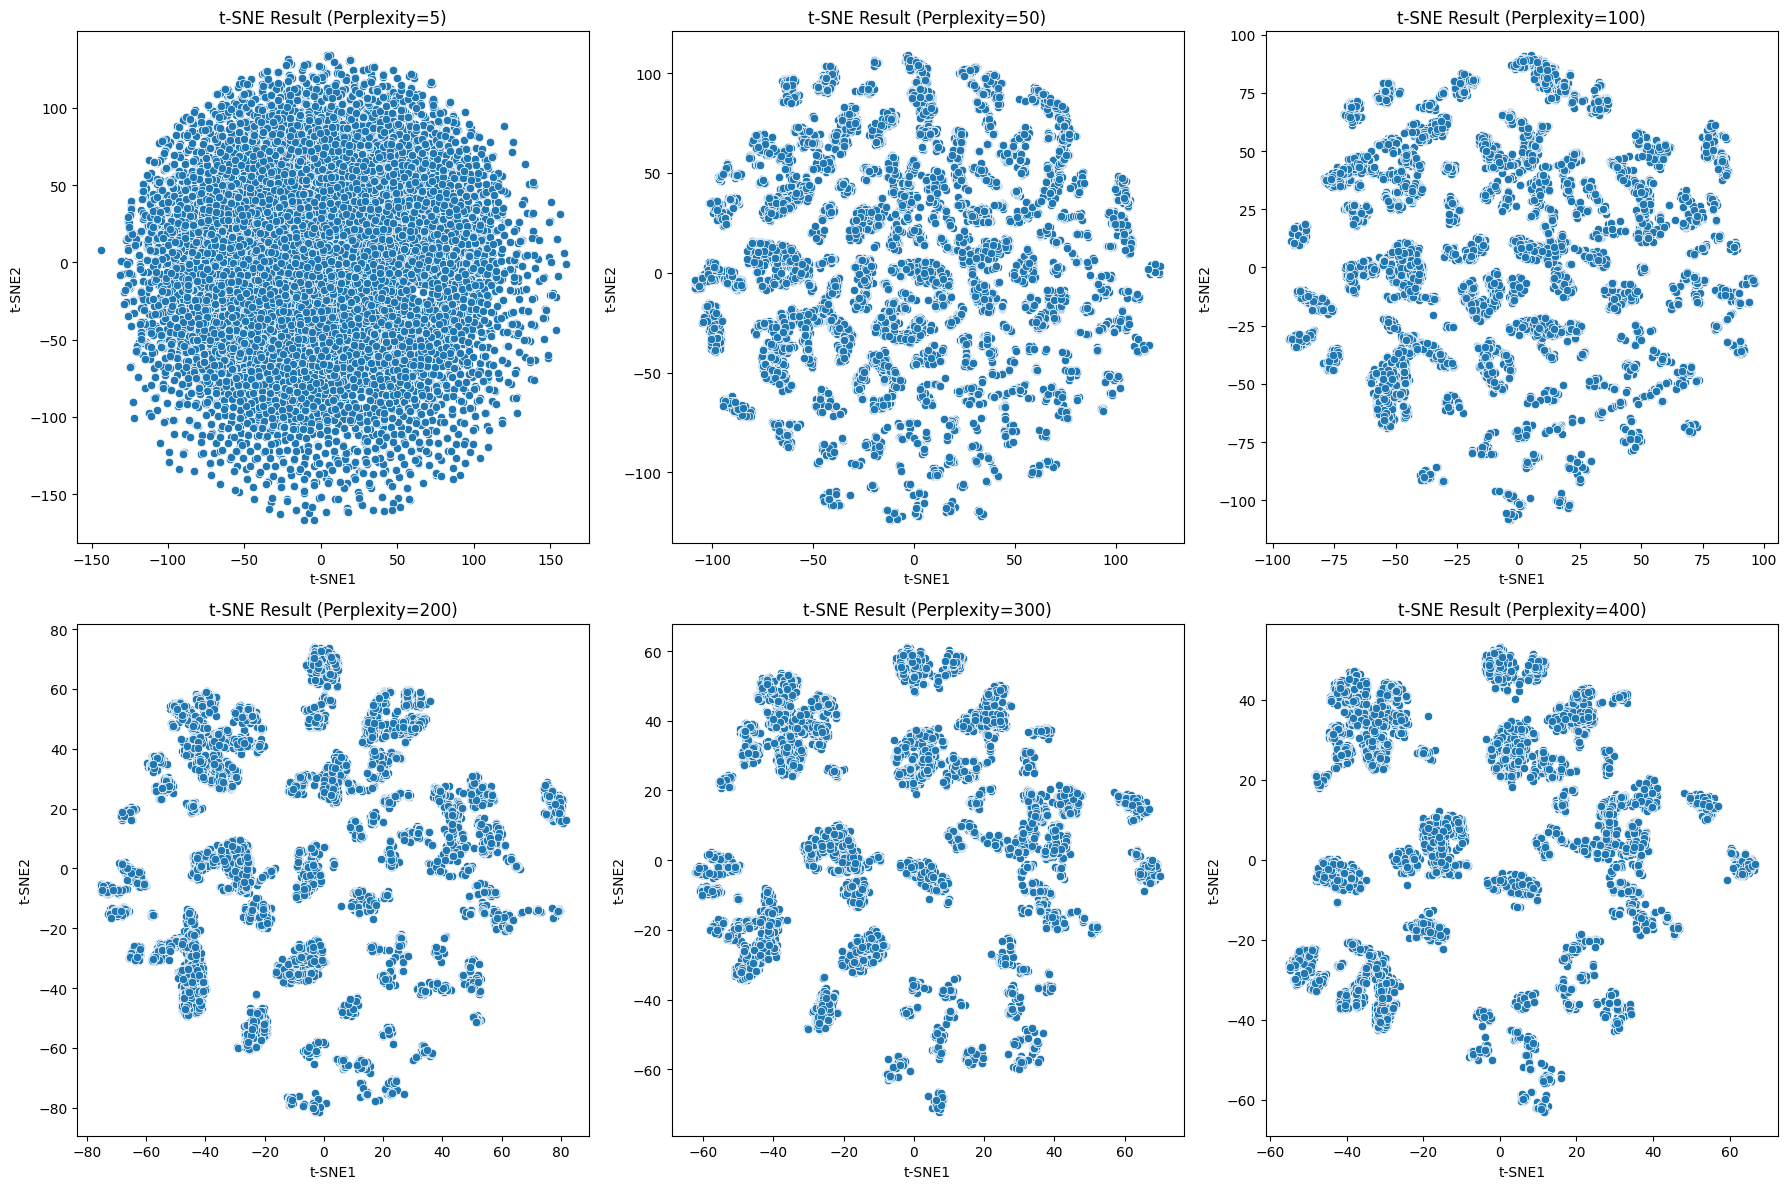

In [124]:
perplexity_values = [5, 50, 100, 200, 300, 400]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, perplexity in enumerate(perplexity_values):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_tsne = tsne.fit_transform(data)
    
    reduced_tsne_df = pd.DataFrame(reduced_tsne, columns=['t-SNE1', 't-SNE2'])
    
    row = i // 3
    col = i % 3
    sns.scatterplot(x='t-SNE1', y='t-SNE2', data=reduced_tsne_df, ax=axes[row, col])
    axes[row, col].set_title(f't-SNE Result (Perplexity={perplexity})')

plt.tight_layout()
plt.show()

##### Từ các đồ thị ta có thể thấy lựa chọn biến perplexity = 300 là hợp lý vì:
+ Đủ lớn để dữ liệu hình thành tính chất cụm có thể phân tách thành các cụm có tính chất khác nhau
+ Không quá lớn để xảy ra hiện tượng Crowding problem. Một hiện tượng xảy ra khi các điểm dữ liệu trong không gian gốc được biểu diễn gần nhau quá mức trong không gian giảm chiều. Điều này có thể dẫn đến việc quá nhiều điểm dữ liệu được ánh xạ vào một vùng nhỏ của không gian giảm chiều, gây ra sự chồng chéo và gắn kết của các điểm. 

----------------

### Mô hình K-means

In [ ]:
df_no_encoded = pd.read_csv('helpper/data_no_encoded.csv')
data_tnse = pd.read_csv('helpper/reduced_data_tsne300.csv')

<h3>1. Xác định k value,số cụm</h3>

In [ ]:
data_array = data[['Năm sản xuất','Tình trạng','Kiểu dáng','Số Km đã đi','Xuất xứ',
                'Hãng xe','Dẫn động','Số chỗ ngồi','Địa điểm','Động cơ','Hộp số','Giá']].values

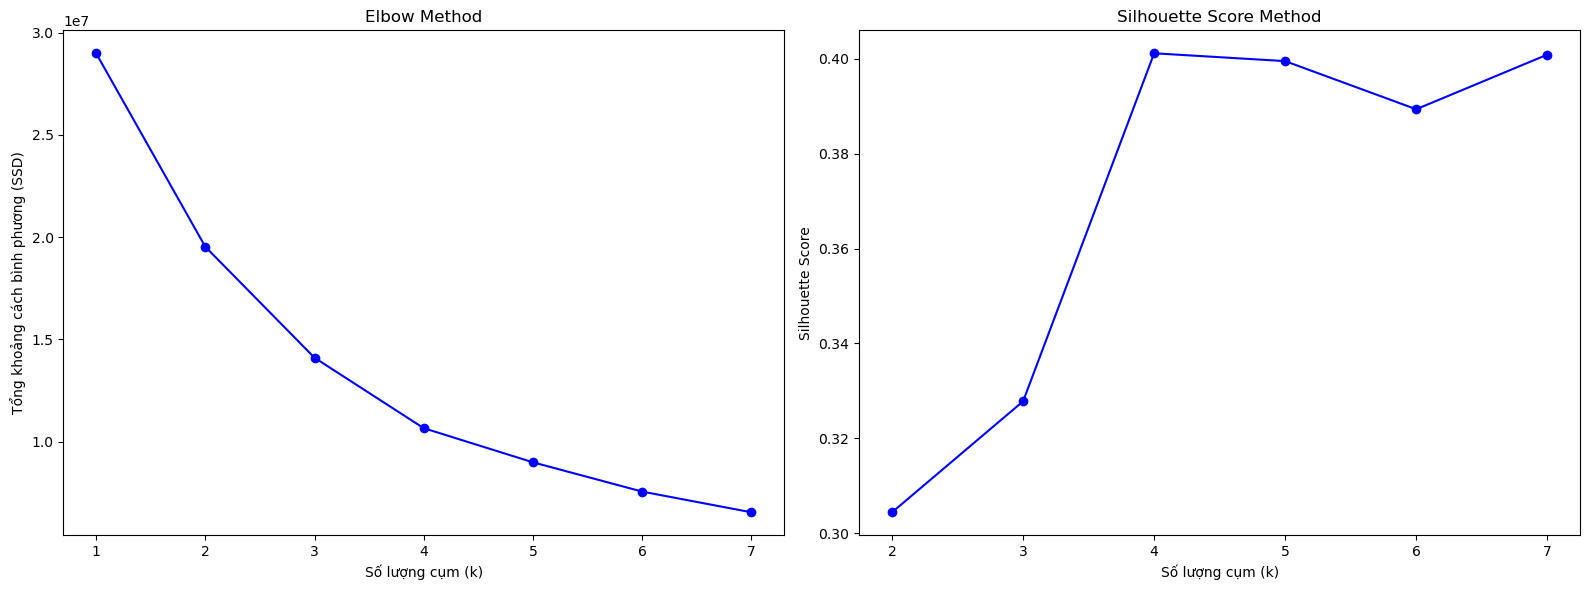

Best K: 4


In [ ]:
k_range = range(1, 8)  # Điều chỉnh phạm vi k cho phù hợp
ssd = []
silhouette_scores = []

# Chạy k-means cho mỗi giá trị của k và tính SSD và Silhouette Score
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_array)
    ssd.append(kmeans.inertia_)
    if k > 1:  # Silhouette Score không tính cho k=1
        cluster_labels = kmeans.predict(data_array)
        silhouette_avg = silhouette_score(data_array, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(float('nan'))  # Để khoảng cách cho k=1

# Khởi tạo figure và hai subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Vẽ biểu đồ Elbow
axes[0].plot(k_range, ssd, 'bo-')
axes[0].set_xlabel('Số lượng cụm (k)')
axes[0].set_ylabel('Tổng khoảng cách bình phương (SSD)')
axes[0].set_title('Elbow Method')

# Vẽ biểu đồ Silhouette Score
axes[1].plot(k_range[1:], silhouette_scores[1:], 'bo-')  # Bỏ qua k=1 cho Silhouette Score
axes[1].set_xlabel('Số lượng cụm (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score Method')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

# Xác định k tốt nhất từ Silhouette Score
best_k = k_range[np.nanargmax(silhouette_scores[1:]) + 1]  # Thêm 1 để bù cho chỉ số k=1 bị bỏ qua
print("Best K:", best_k)

- Với elbow method chưa xác định được chính xác giá trị của K
- Với Silhouette Score ta xác định được số cụm K = 4

<h3>2. Clustering with K = 4</h3>

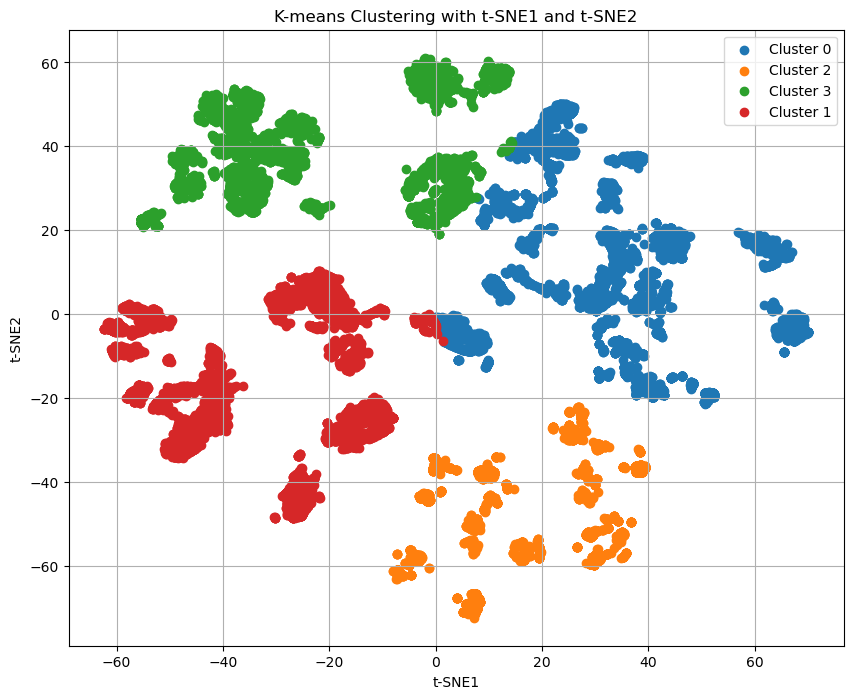

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_tnse)

# Gán nhãn cụm cho mỗi điểm dữ liệu
data_tnse['KMean'] = kmeans.labels_

# In ra một số dòng đầu của DataFrame sau khi đã gán nhãn cụm
plt.figure(figsize=(10, 8))

# Vẽ biểu đồ phân tán cho từng cụm
for cluster in data_tnse['KMean'].unique():
    cluster_data = data_tnse[data_tnse['KMean'] == cluster]
    plt.scatter(cluster_data['t-SNE1'], cluster_data['t-SNE2'], label=f'Cluster {cluster}')

# Đặt tiêu đề và nhãn trục
plt.title('K-means Clustering with t-SNE1 and t-SNE2')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

<h3>3. Plot</h3>

In [ ]:
df_no_encoded['KMean'] = data_tnse['KMean']
df_no_encoded.to_csv('helpper/data_clustered.csv', index=False)

`a. Phân phối số lượng cụm theo giá`

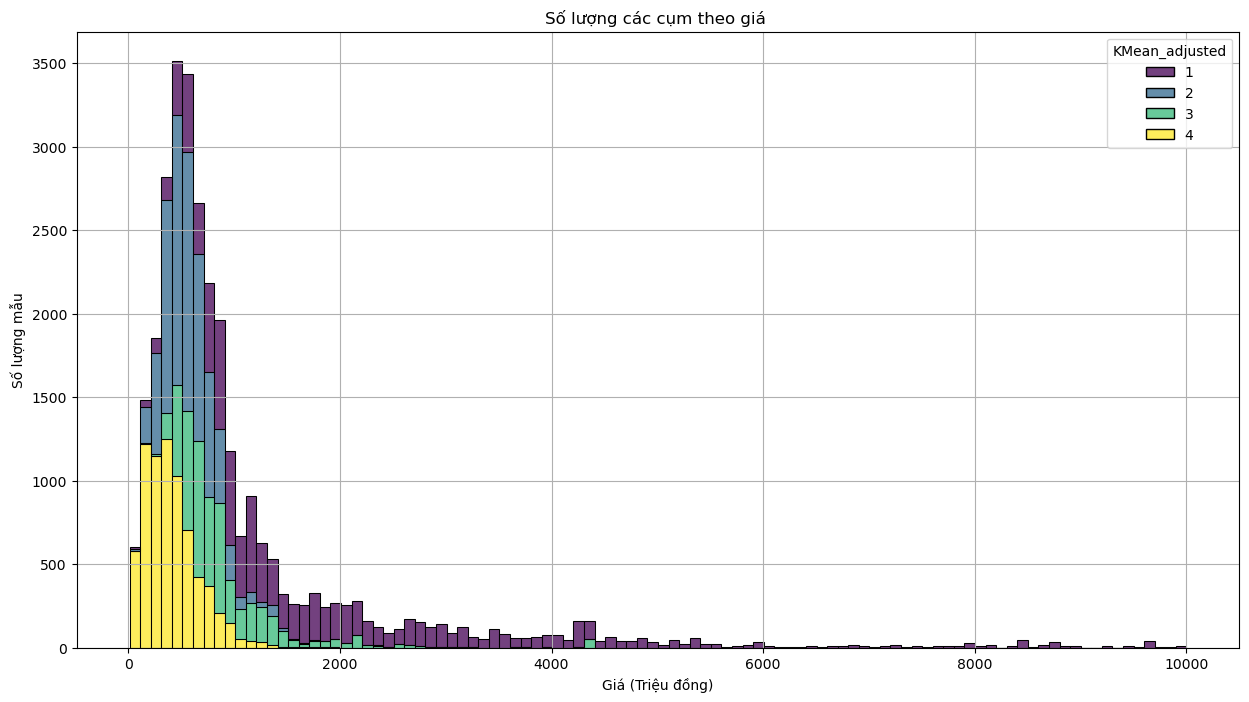

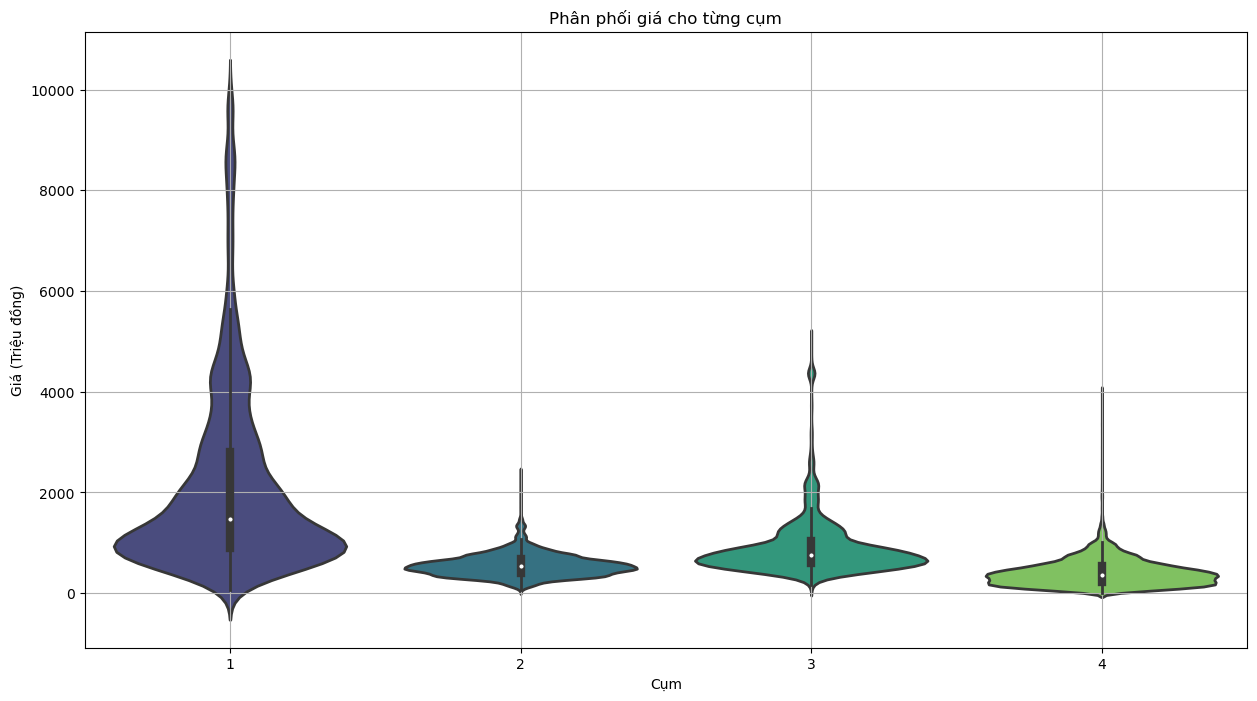

In [ ]:
data_clustered = pd.read_csv('helpper/data_clustered.csv')
data_clustered['KMean_adjusted'] = data_clustered['KMean'] + 1

plt.figure(figsize=(15, 8))
sns.histplot(data=data_clustered, x='Giá', hue='KMean_adjusted', palette='viridis', multiple='stack', bins = 100)
# plt.legend(labels=['Cụm 4', 'Cụm 3', 'Cụm 2', 'Cụm 1'], title='Cụm', title_fontsize='large', loc='upper right', fontsize='medium')
plt.title(f'Số lượng các cụm theo giá ')
plt.xlabel('Giá (Triệu đồng)')
plt.ylabel('Số lượng mẫu')
plt.grid(True)
plt.show()

#VIOLIN PLOT


plt.figure(figsize=(15, 8))
sns.violinplot(data=data_clustered, x='KMean_adjusted', y='Giá', palette='viridis', linewidth=2, width=0.8, scale='width')

# Đặt tiêu đề và nhãn cho trục
plt.title('Phân phối giá cho từng cụm')
plt.xlabel('Cụm')
plt.ylabel('Giá (Triệu đồng)')

# Hiển thị biểu đồ
plt.grid(True)
plt.show()

- Cụm 1 chiếm số lượng nhiều nhất và phân bổ trải dài nhất trong 4 cụm
- Ở khoảng giá 1.5 tỉ trở xuống, số lượng mẫu cụm 2 nhiều hơn cụm 3 nhưng cụm 3 trải dài hơn và trải đến 4 tỉ
- Cụm 4 nhìn chung có số lượng ít nhất và phân bổ chủ yếu trong khoảng 0 tới 1 tỉ

`b. Phân phối số lượng cụm theo số Km đã đi`

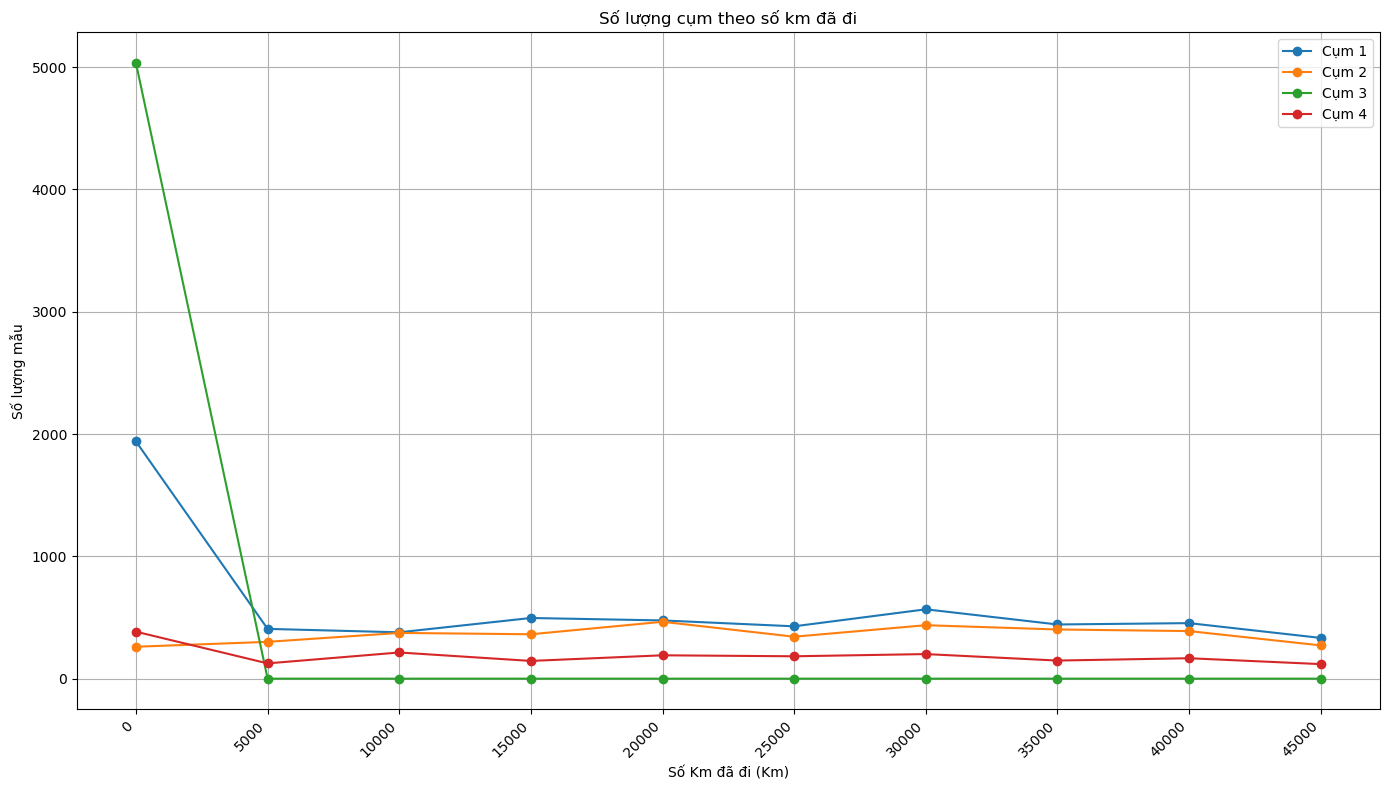

In [ ]:
data_clustered = pd.read_csv('helpper/data_clustered.csv')
    
data_clustered['Số Km đã đi'] = data_clustered['Số Km đã đi'].astype(int)

# Chia cột 'Số Km đã đi' thành các khoảng mỗi 50,000 km
max_km = 50000
bins_range = 5000
bins = range(0, max_km + bins_range, bins_range)
labels = [f'{i}' for i in bins[:-1]]
data_clustered['Km_bins'] = pd.cut(data_clustered['Số Km đã đi'], bins=bins, labels=labels, right=False)

# Đếm số lượng mẫu trong mỗi khoảng của từng cụm
counts = data_clustered.groupby(['Km_bins', 'KMean']).size().reset_index(name='Count')

# Tạo line plot
plt.figure(figsize=(14, 8))

# Vẽ đường cho từng cụm
for cluster in counts['KMean'].unique():
    cluster_data = counts[counts['KMean'] == cluster]
    plt.plot(cluster_data['Km_bins'], cluster_data['Count'], marker='o', label=f'Cụm {cluster + 1}')

# Đặt tiêu đề và nhãn trục
plt.title('Số lượng cụm theo số km đã đi')
plt.xlabel('Số Km đã đi (Km)')
plt.ylabel('Số lượng mẫu')
plt.legend()
plt.grid(True)

# Xoay nhãn trục x để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

- Cụm 2 và Cụm 4 khá tương đồng nhau, dao động ổn định khoảng 500 mẫu trải dài đến hết số Km đã đi
- Cụm 1 nhìn chung có số lượng phân bổ nhiều hơn cụm 2 và 3
- Cụm 3 chỉ tập trung duy nhất ở 0km  

`c. Tỉ lệ phân phối số lượng cụm theo các hãng xe`

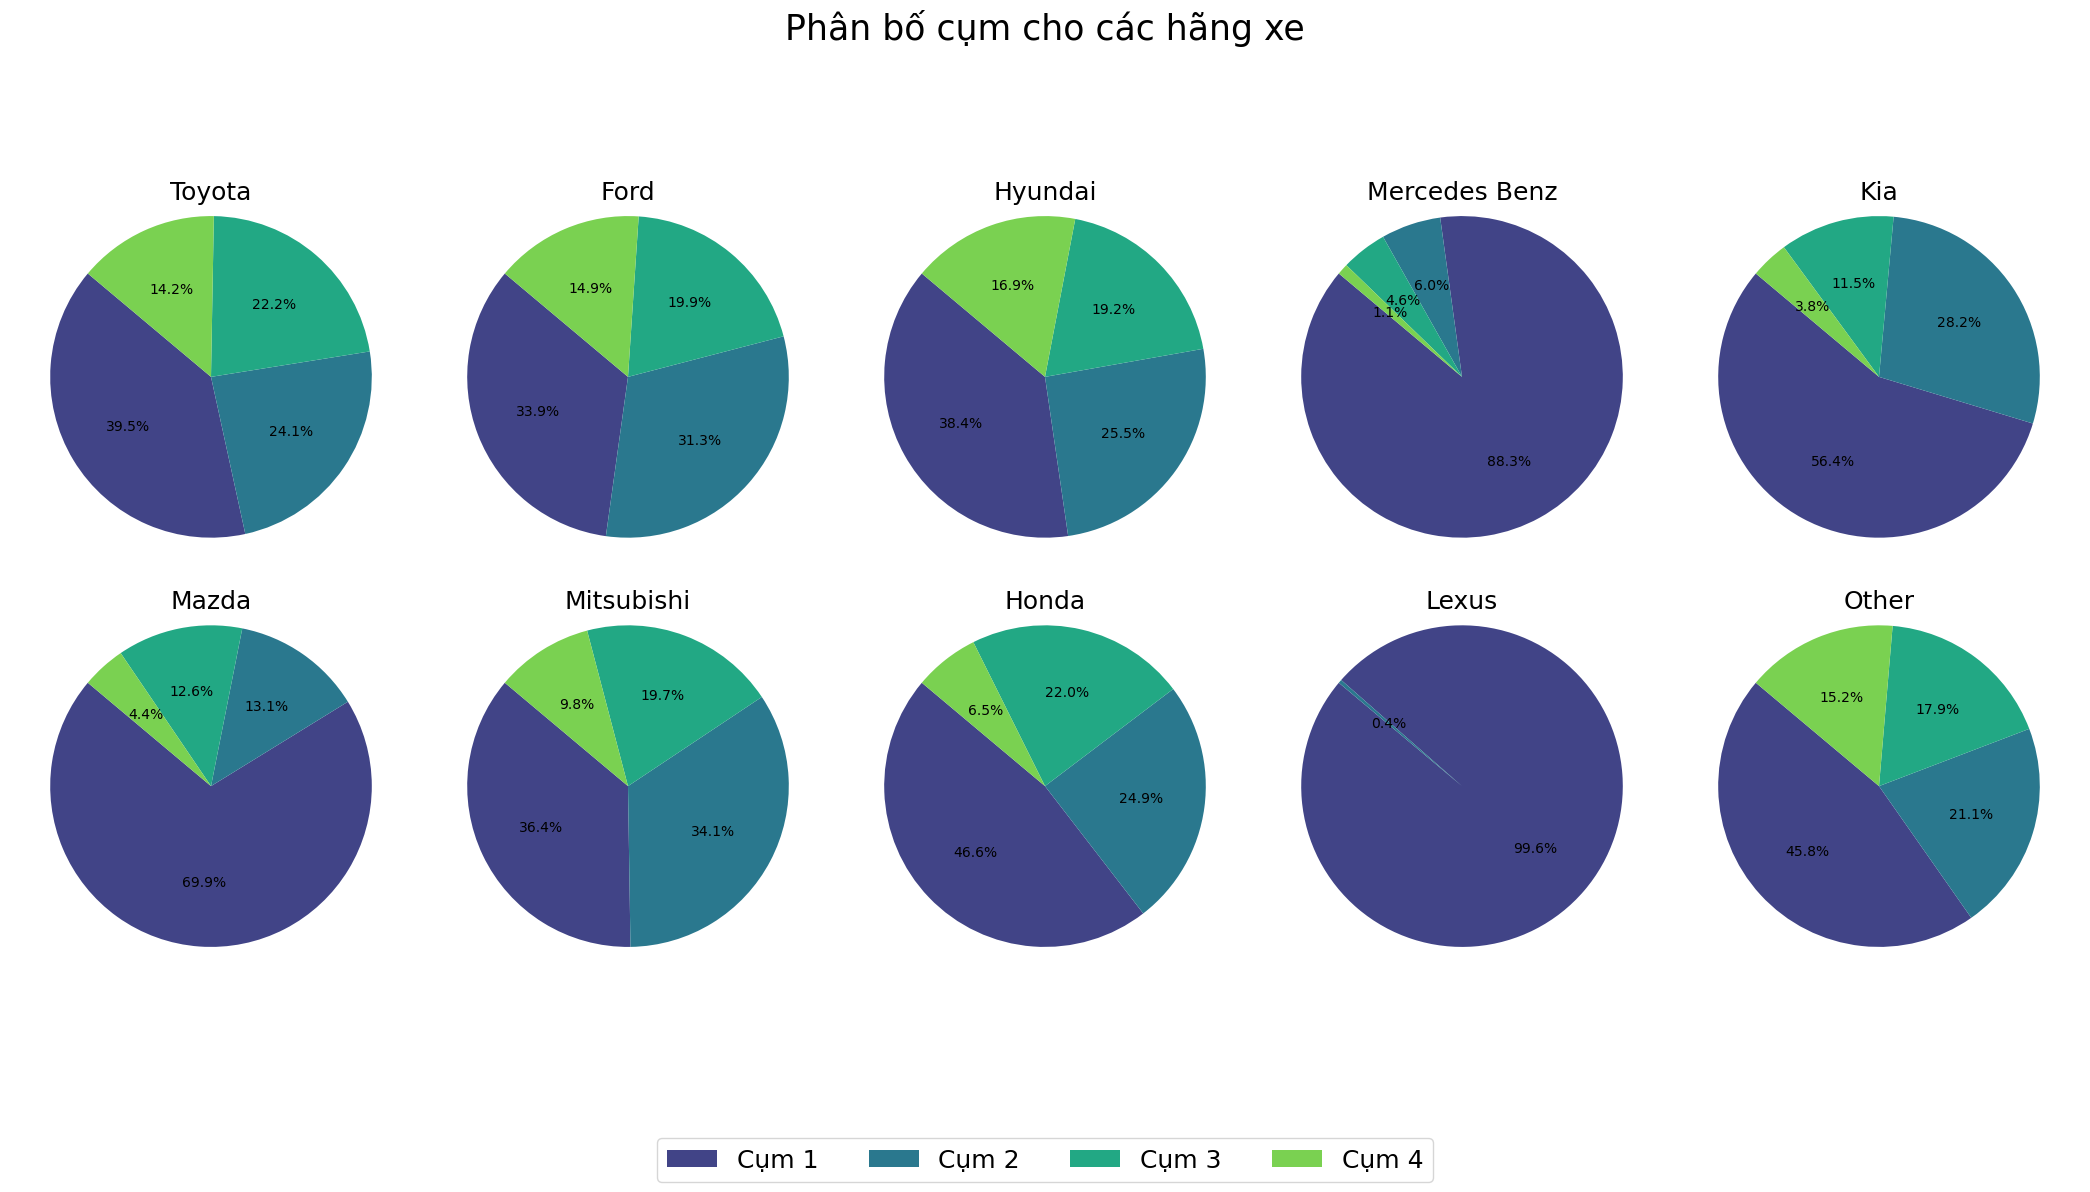

In [ ]:
# Đọc dữ liệu từ file CSV
data_clustered = pd.read_csv('helpper/data_clustered.csv')

# Lấy 9 hãng xe nổi bật nhất
top_brands = data_clustered['Hãng xe'].value_counts().nlargest(9).index

# Tạo một cột mới để gộp các hãng xe còn lại thành nhóm 'Other'
data_clustered['Hãng xe điều chỉnh'] = data_clustered['Hãng xe'].apply(lambda x: x if x in top_brands else 'Other')

# Lọc dữ liệu chỉ chứa 9 hãng xe nổi bật nhất và nhóm 'Other'
adjusted_brands = top_brands.tolist() + ['Other']
top_data_clustered = data_clustered[data_clustered['Hãng xe điều chỉnh'].isin(adjusted_brands)]

# Khởi tạo figure và axes
fig, axes = plt.subplots(2, 5, figsize=(21, 12))

# Màu sắc cho các cụm
colors = sns.color_palette('viridis', len(data_clustered['KMean'].unique()))

# Vẽ biểu đồ tròn cho mỗi hãng xe điều chỉnh
for ax, brand in zip(axes.flatten(), adjusted_brands):
    brand_data = top_data_clustered[top_data_clustered['Hãng xe điều chỉnh'] == brand]
    brand_counts = brand_data['KMean'].value_counts()
    
    # Biểu đồ tròn
    wedges, texts, autotexts = ax.pie(
        brand_counts, 
        labels=None,  # Bỏ chú thích
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors,
       
    )

    ax.set_title(brand, fontsize=18, y=0.92)

# Tạo một legend chung
fig.legend(wedges, [f'Cụm {i + 1}' for i in range(len(colors))], loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5, fontsize='18')

# Đặt tiêu đề chung cho toàn bộ figure
plt.suptitle('Phân bố cụm cho các hãng xe', fontsize=25)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Hiển thị biểu đồ
plt.show()

- Về hãng xe, nhìn chung Cụm 1 có tỉ lệ số lượng cao nhất trong 4 cụm ở mọi hãng xe
- Tiếp đến là cụm 2 và cụm 3 có tỉ lệ số lượng khá tương đồng
- Cụm 4 có tỉ lệ về số lượng thấp nhất

`d. Tỉ lệ phân phối số lượng cụm theo địa điểm bán`

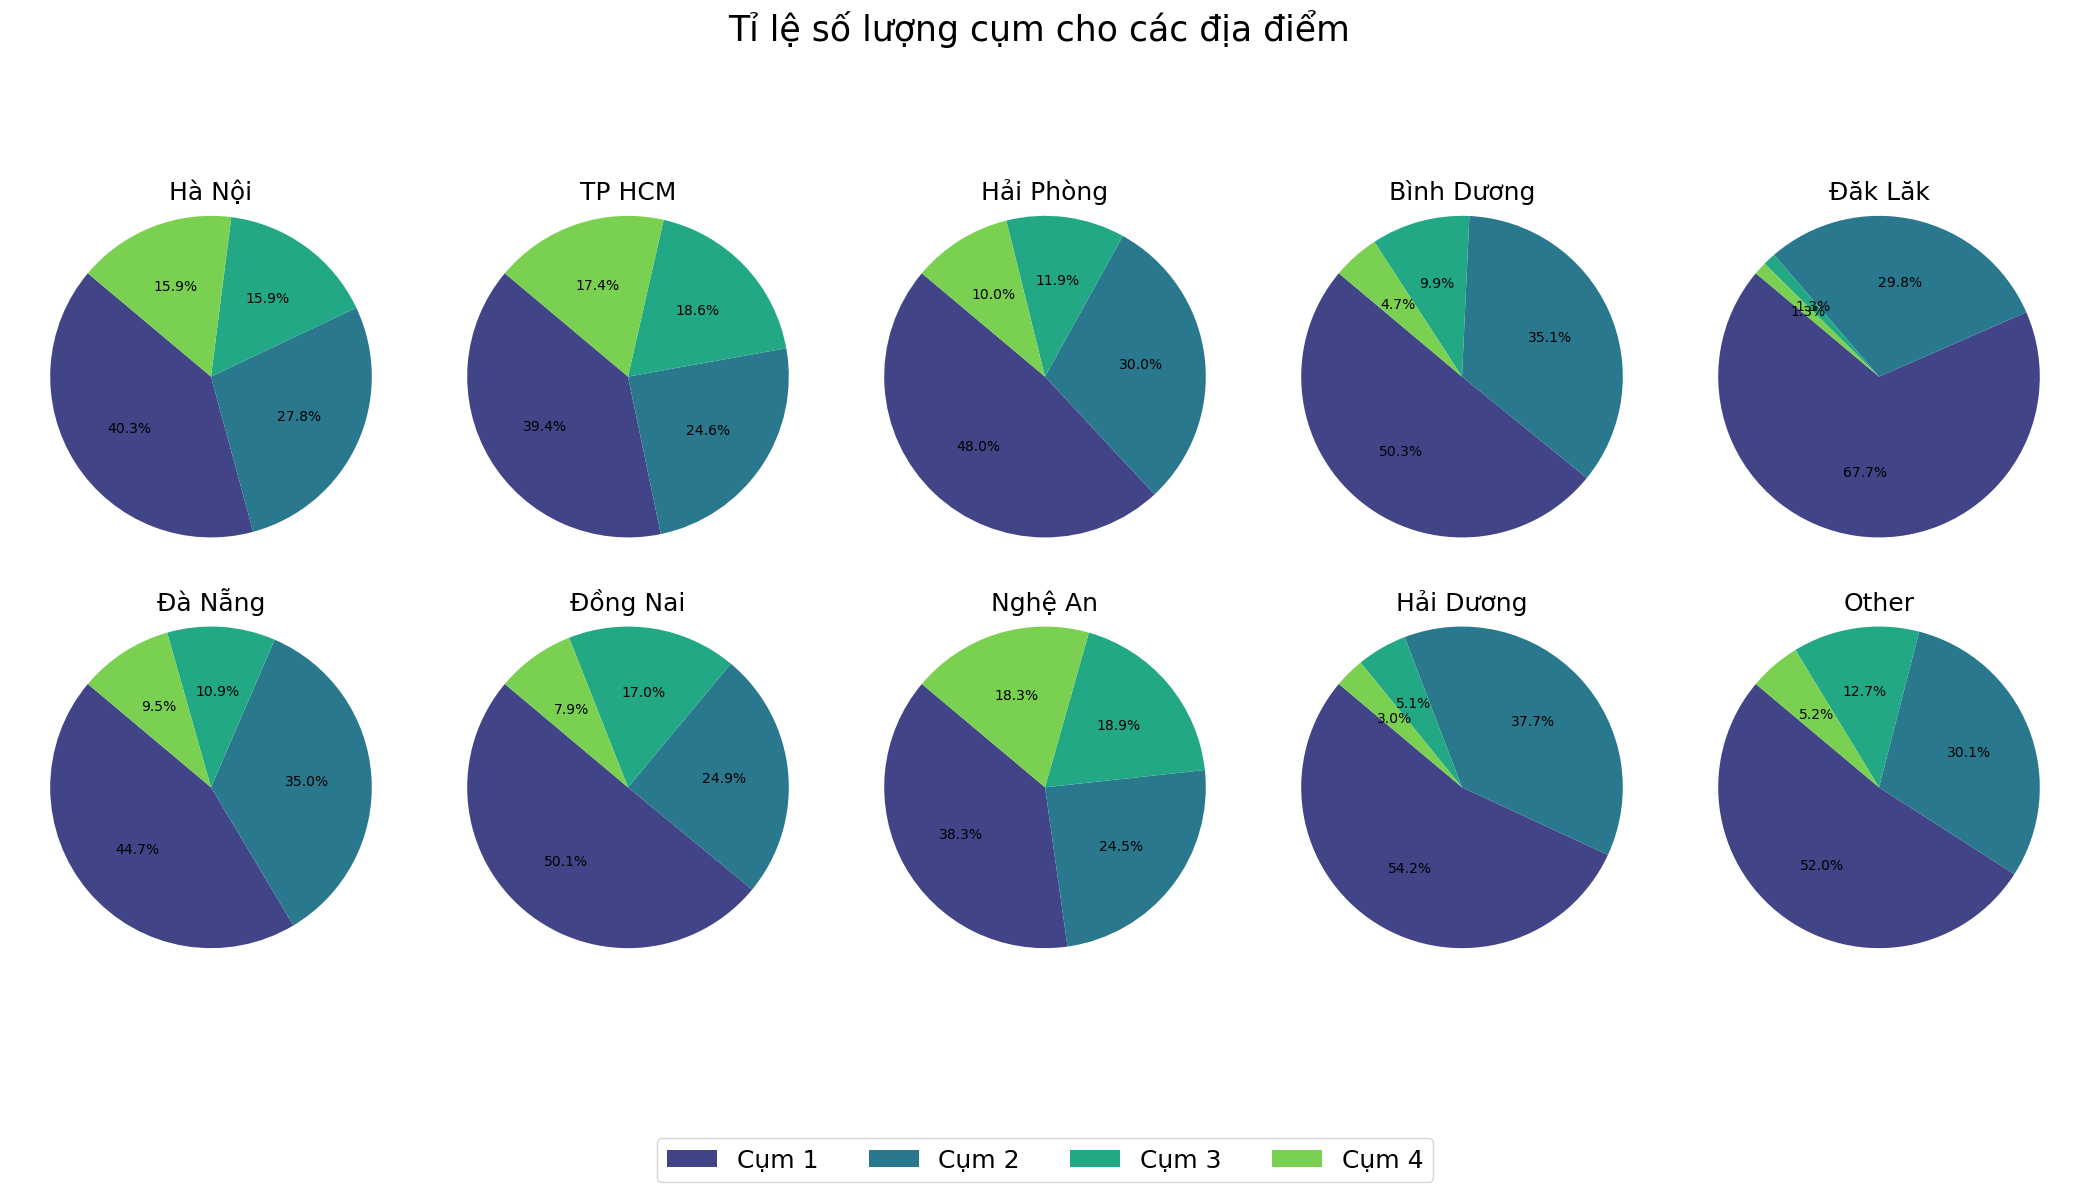

In [ ]:
# Đọc dữ liệu từ file CSV
data_clustered = pd.read_csv('helpper/data_clustered.csv')

# Lấy 9 hãng xe nổi bật nhất
top_brands = data_clustered['Địa điểm'].value_counts().nlargest(9).index

# Tạo một cột mới để gộp các hãng xe còn lại thành nhóm 'Other'
data_clustered['Địa điểm điều chỉnh'] = data_clustered['Địa điểm'].apply(lambda x: x if x in top_brands else 'Other')

# Lọc dữ liệu chỉ chứa 9 hãng xe nổi bật nhất và nhóm 'Other'
adjusted_brands = top_brands.tolist() + ['Other']
top_data_clustered = data_clustered[data_clustered['Địa điểm điều chỉnh'].isin(adjusted_brands)]

# Khởi tạo figure và axes
fig, axes = plt.subplots(2, 5, figsize=(21, 12))

# Màu sắc cho các cụm
colors = sns.color_palette('viridis', len(data_clustered['KMean'].unique()))

# Vẽ biểu đồ tròn cho mỗi hãng xe điều chỉnh
for ax, brand in zip(axes.flatten(), adjusted_brands):
    brand_data = top_data_clustered[top_data_clustered['Địa điểm điều chỉnh'] == brand]
    brand_counts = brand_data['KMean'].value_counts()
    
    # Biểu đồ tròn
    wedges, texts, autotexts = ax.pie(
        brand_counts, 
        labels=None,  # Bỏ chú thích
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors,
       
    )

    ax.set_title(brand, fontsize=18, y=0.92)

# Tạo một legend chung
fig.legend(wedges, [f'Cụm {i + 1}' for i in range(len(colors))], loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5, fontsize='18')

# Đặt tiêu đề chung cho toàn bộ figure
plt.suptitle('Tỉ lệ số lượng cụm cho các địa điểm ', fontsize=25)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Hiển thị biểu đồ
plt.show()

- Cụm 1 có tỉ lệ số lượng cao nhất trong tất cả các địa điểm
- Tiếp đến là cụm 2
- Cụm 3 và 4 có tỉ lệ số lượng tương đồng nhau và thấp nhất trong 4 cụm

`e. Số lượng cụm của 1 vài kiểu dữ liệu khác`

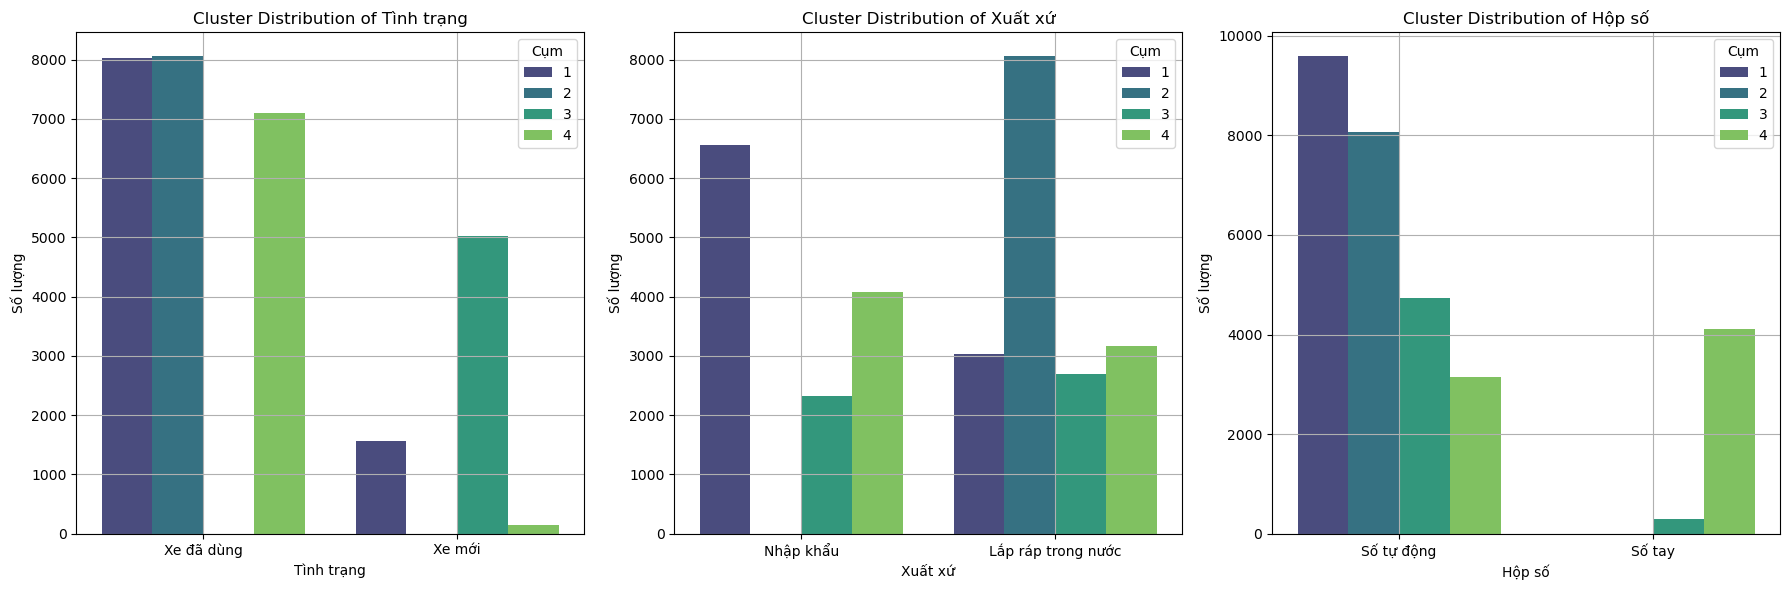

In [ ]:
data = pd.read_csv('helpper/data_clustered.csv')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot cho đặc trưng 'Tình trạng' (kiểu nhị phân)
# Sắp xếp lại dữ liệu dựa trên cột KMean
data.sort_values(by='KMean', inplace=True)

# Chuyển đổi kiểu dữ liệu của cột KMean thành chuỗi
data['KMean'] = data['KMean'].astype(str)
data['Cụm'] = data['KMean'].replace({'0': '1', '1': '2', '2': '3', '3': '4'})
sns.countplot(ax=axes[0],  hue='Cụm', x='Tình trạng', data=data, palette='viridis')
axes[0].set_title('Cluster Distribution of Tình trạng')
axes[0].set_xlabel('Tình trạng')
axes[0].set_ylabel('Số lượng')
axes[0].grid(True)

# Plot cho đặc trưng 'Xuất xứ' (kiểu nhị phân)  
sns.countplot(ax=axes[1], x='Xuất xứ', hue='Cụm', data=data, palette='viridis')
axes[1].set_title('Cluster Distribution of Xuất xứ')
axes[1].set_xlabel('Xuất xứ')
axes[1].set_ylabel('Số lượng')
axes[1].grid(True)

# Plot cho đặc trưng 'Hộp số' (kiểu nhị phân)
sns.countplot(ax=axes[2], x='Hộp số', hue='Cụm', data=data, palette='viridis')
axes[2].set_title('Cluster Distribution of Hộp số')
axes[2].set_xlabel('Hộp số')
axes[2].set_ylabel('Số lượng')
axes[2].grid(True)

# Tăng khoảng cách giữa các subplot
plt.tight_layout()

# Hiển thị hình
plt.show()

- Về tình trạng, có sự phân bổ số lượng không đều ở 4 cụm 
- Về xuất xứ, cụm 1 và 2 có phân bổ không đều về nhập khẩu và trong nước, cụm 3 và 4 có số lượng phân bổ khá đều
- Về hộp số, cụm 4 phân bổ đều ở 2 hộp số, 3 cụm còn lại không đều nhau

### Mô hình GMM (Gaussian Mixture Model)

- Đoạn mã kiểm tra lựa chọn giá trị n_components phù hợp cho mô hình dựa trên 2 thông số Elbow Method và Silhouette Score

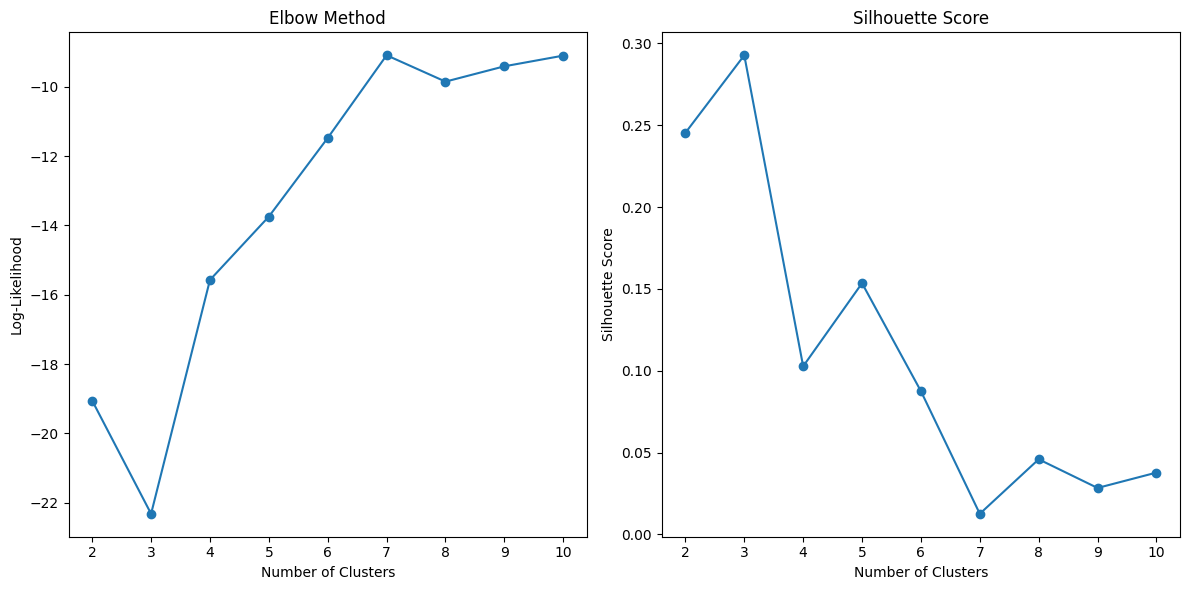

In [16]:
elbow_scores = []
silhouette_scores = []

# Number of clusters to try
k_values = range(2, 11)

# Loop through each k value
for k in k_values:
    # Fit GMM model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data)
    
    # Elbow method: Compute the log-likelihood and append to the list
    elbow_scores.append(gmm.score(data))
    
    # Silhouette Score: Compute silhouette score and append to the list
    labels = gmm.predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

# Plot Elbow Method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, elbow_scores, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Log-Likelihood')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

#### Nhận xét:
- Dựa vào 2 đồ thị trên ta có thể tìm được k thích hợp là 3 khi Log-Likelihood đủ nhỏ đồng thời Silhouette Score đủ lớn (đạt cực tiểu và cực đại địa phương)

- Từ đó tiến hành phân cụm dữ liệu với n_components bằng 3

In [4]:
n_clusters = 3

gmm = GaussianMixture(n_components=n_clusters, random_state=42)

clusters = gmm.fit_predict(data)

data['Cụm số'] = clusters
data.to_csv('helpper/data_phancum.csv', index=False)
data.head()

Năm sản xuất  Tình trạng  Kiểu dáng  Số Km đã đi  Xuất xứ  Hãng xe  \
0          2022           1          5    -0.134459        1       18   
1          2024           0          5    -0.537837        1       46   
2          2007           1          6     0.513257        1       69   
3          2024           0          5    -0.537837        1       46   
4          2023           0          5    -0.537837        1       64   

   Dẫn động  Số chỗ ngồi  Địa điểm  Động cơ  Hộp số       Giá  Cụm số  
0         3            7        17        5       1  0.569986       2  
1         3            7        17       45       1  2.069264       0  
2         2            5        46       53       1 -0.519481       1  
3         1            7        17       59       1  6.096681       0  
4         2            7        45       28       0 -0.297258       0

- Dán cụm vào từng giá trị phù hợp để thực hiện đánh giá, đọc từ các file csv

In [ ]:
data_pc = pd.read_csv('helpper/data_phancum.csv')
data_noencoded = pd.read_csv('helpper/data_no_encoded.csv')
data_noencoded['GMM'] = data_pc['Cụm số']
data_noencoded.to_csv('helpper/data_gmm.csv', index=False)

Sử dụng phương pháp giảm chiều bên trên (t-sne) để tiến hành trực quan hóa sự phân cụm của đồ thị 

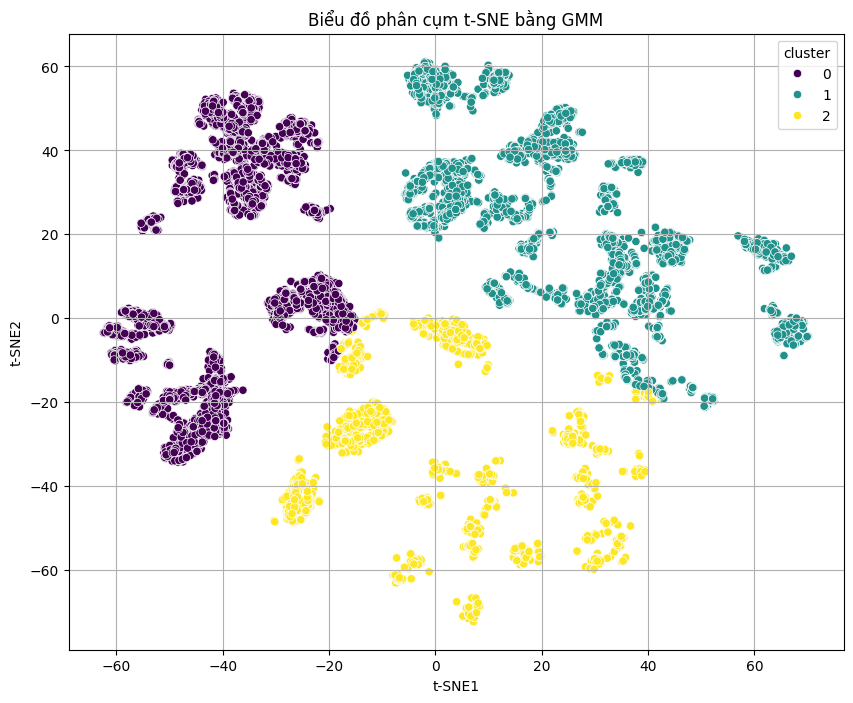

In [17]:
# Phân cụm bằng thuật toán GMM
reduced_data_tsne_300 = pd.read_csv('helpper/reduced_data_tsne_300.csv')
gmm = GaussianMixture(n_components=3, random_state=42)
reduced_data_tsne_300['cluster'] = gmm.fit_predict(reduced_data_tsne_300)

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.scatterplot(data=reduced_data_tsne_300, x='t-SNE1', y='t-SNE2', hue='cluster', palette='viridis')
plt.title('Biểu đồ phân cụm t-SNE bằng GMM')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.grid(True)
plt.show()

##### Tiến hành đánh giá nhận xét các cụm được phân ra đối với các đặc trưng ban đầu của dữ liệu từ đó rút ra được nhận xét, đặc điểm của từng cụm

- 3 đặc trưng nhị phân là Tình trạng, xuất xứ và hộp số

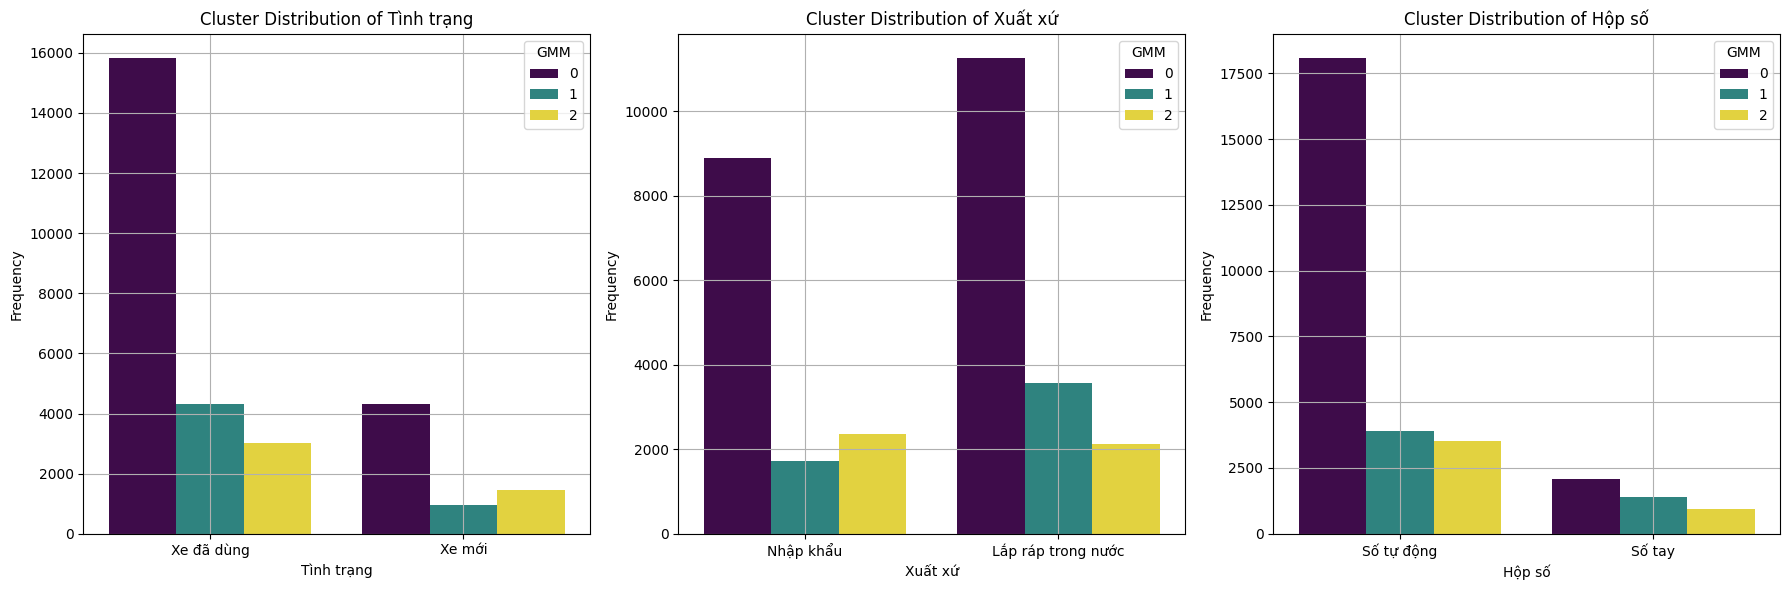

In [18]:
data_pc = pd.read_csv('helpper/data_phancum.csv')
data_noencoded = pd.read_csv('clean_data_train.csv')
data_noencoded['GMM'] = data_pc['Cụm số']
# data_noencoded.to_csv('data_gmm.csv', index=False)
data = data_noencoded

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot cho đặc trưng 'Tình trạng' (kiểu nhị phân)
sns.countplot(ax=axes[0], x='Tình trạng', hue='GMM', data=data, palette='viridis')
axes[0].set_title('Cluster Distribution of Tình trạng')
axes[0].set_xlabel('Tình trạng')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot cho đặc trưng 'Xuất xứ' (kiểu nhị phân)
sns.countplot(ax=axes[1], x='Xuất xứ', hue='GMM', data=data, palette='viridis')
axes[1].set_title('Cluster Distribution of Xuất xứ')
axes[1].set_xlabel('Xuất xứ')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Plot cho đặc trưng 'Hộp số' (kiểu nhị phân)
sns.countplot(ax=axes[2], x='Hộp số', hue='GMM', data=data, palette='viridis')
axes[2].set_title('Cluster Distribution of Hộp số')
axes[2].set_xlabel('Hộp số')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

# Tăng khoảng cách giữa các subplot
plt.tight_layout()

# Hiển thị hình
plt.show()

#### Nhận xét
Dựa vào đồ thị ta thấy:
- Cụm thứ nhất Phân bố chủ yếu ở Tình trạng xe đã dùng, Hộp số tự động và xuất xứ có phân bố tương đối đều
- Cụm thứ hai phân bố tương tụ cụm thứ nhất ở cả Tình trạng, Hộp số và xuất xứ nhưng với số lượng ít hơn 
- Cụm thứ ba phân bố chủ yếu hơn ở tình trạng xe mới, hộp số tự động và xuất xứ nước ngoài

- Đồ thị phân bố các cụm trên đặc trưng Giá

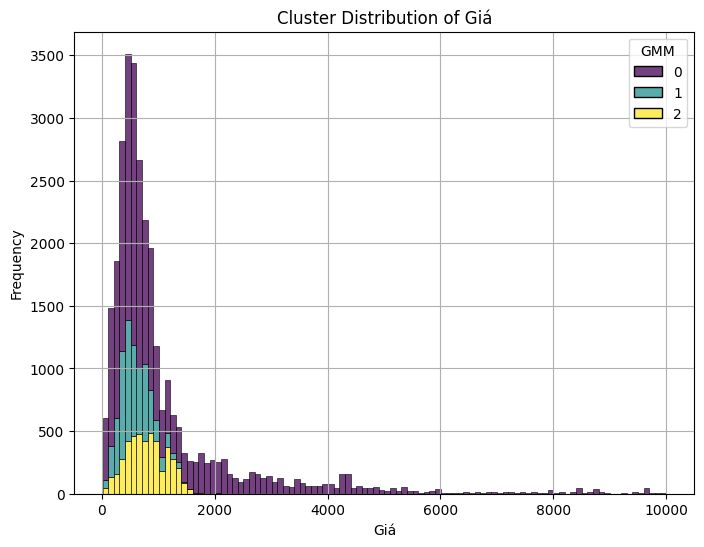

In [19]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='Giá', hue='GMM', palette='viridis', multiple='stack', bins=100)
plt.title(f'Cluster Distribution of {'Giá'}')
plt.xlabel('Giá')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Nhận xét: 
- Cụm thứ nhất có phân bố khoảng giá rộng và số lượng lớn
- Cụm thứ hai có phân bố hẹp hơn (dưới 2 tỷ) cũng như số lượng ít hơn tương đối
- Cụm thứ ba có phân bố và số lượng tương đối thấp, giá cả giao động mức bình dân

- Phân bố các cụm trên đặc trưng động cơ

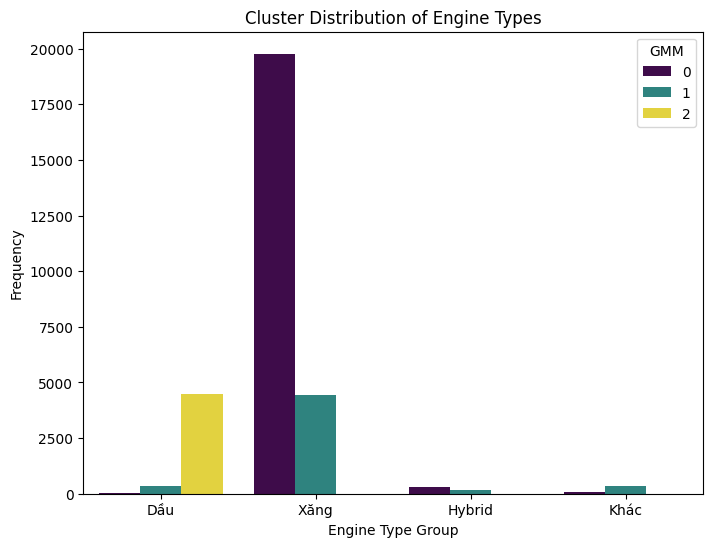

In [20]:
def group_engine_type(engine):
    if 'Xăng' in engine:
        return 'Xăng'
    elif 'Dầu' in engine:
        return 'Dầu'
    elif 'Hybrid' in engine:
        return 'Hybrid'
    else:
        return 'Khác'

data['Nhóm động cơ'] = data['Động cơ'].apply(group_engine_type)

# Vẽ đồ thị số lượng của từng nhóm động cơ dựa trên hue là trường GMM
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Nhóm động cơ', hue='GMM', palette='viridis')
plt.title('Cluster Distribution of Engine Types')
plt.xlabel('Engine Type Group')
plt.ylabel('Frequency')
plt.show()


#### Nhận xét:
- Cụm số một tập trung chủ yếu ở động cơ Xăng, chiếu hầu hết các xe kể cả số lượng lẫn thành phần
- Cụm số hai có phân bố ở 4 loại động cơ nhưng vẫn tập trung chủ yếu ở động cơ xăng
- Cụm số ba tập trung hầu hết ở động cơ dầu chiếm gần hết thị phần xe động cơ dầu

- Sự phân bố của các cụm trên đặc trưng địa điểm (Xét 10 địa điểm lớn nhất và các điểm còn lại gộp thành địa điểm thứ 11)

- Tỉ lệ phân phối cụm địa điểm

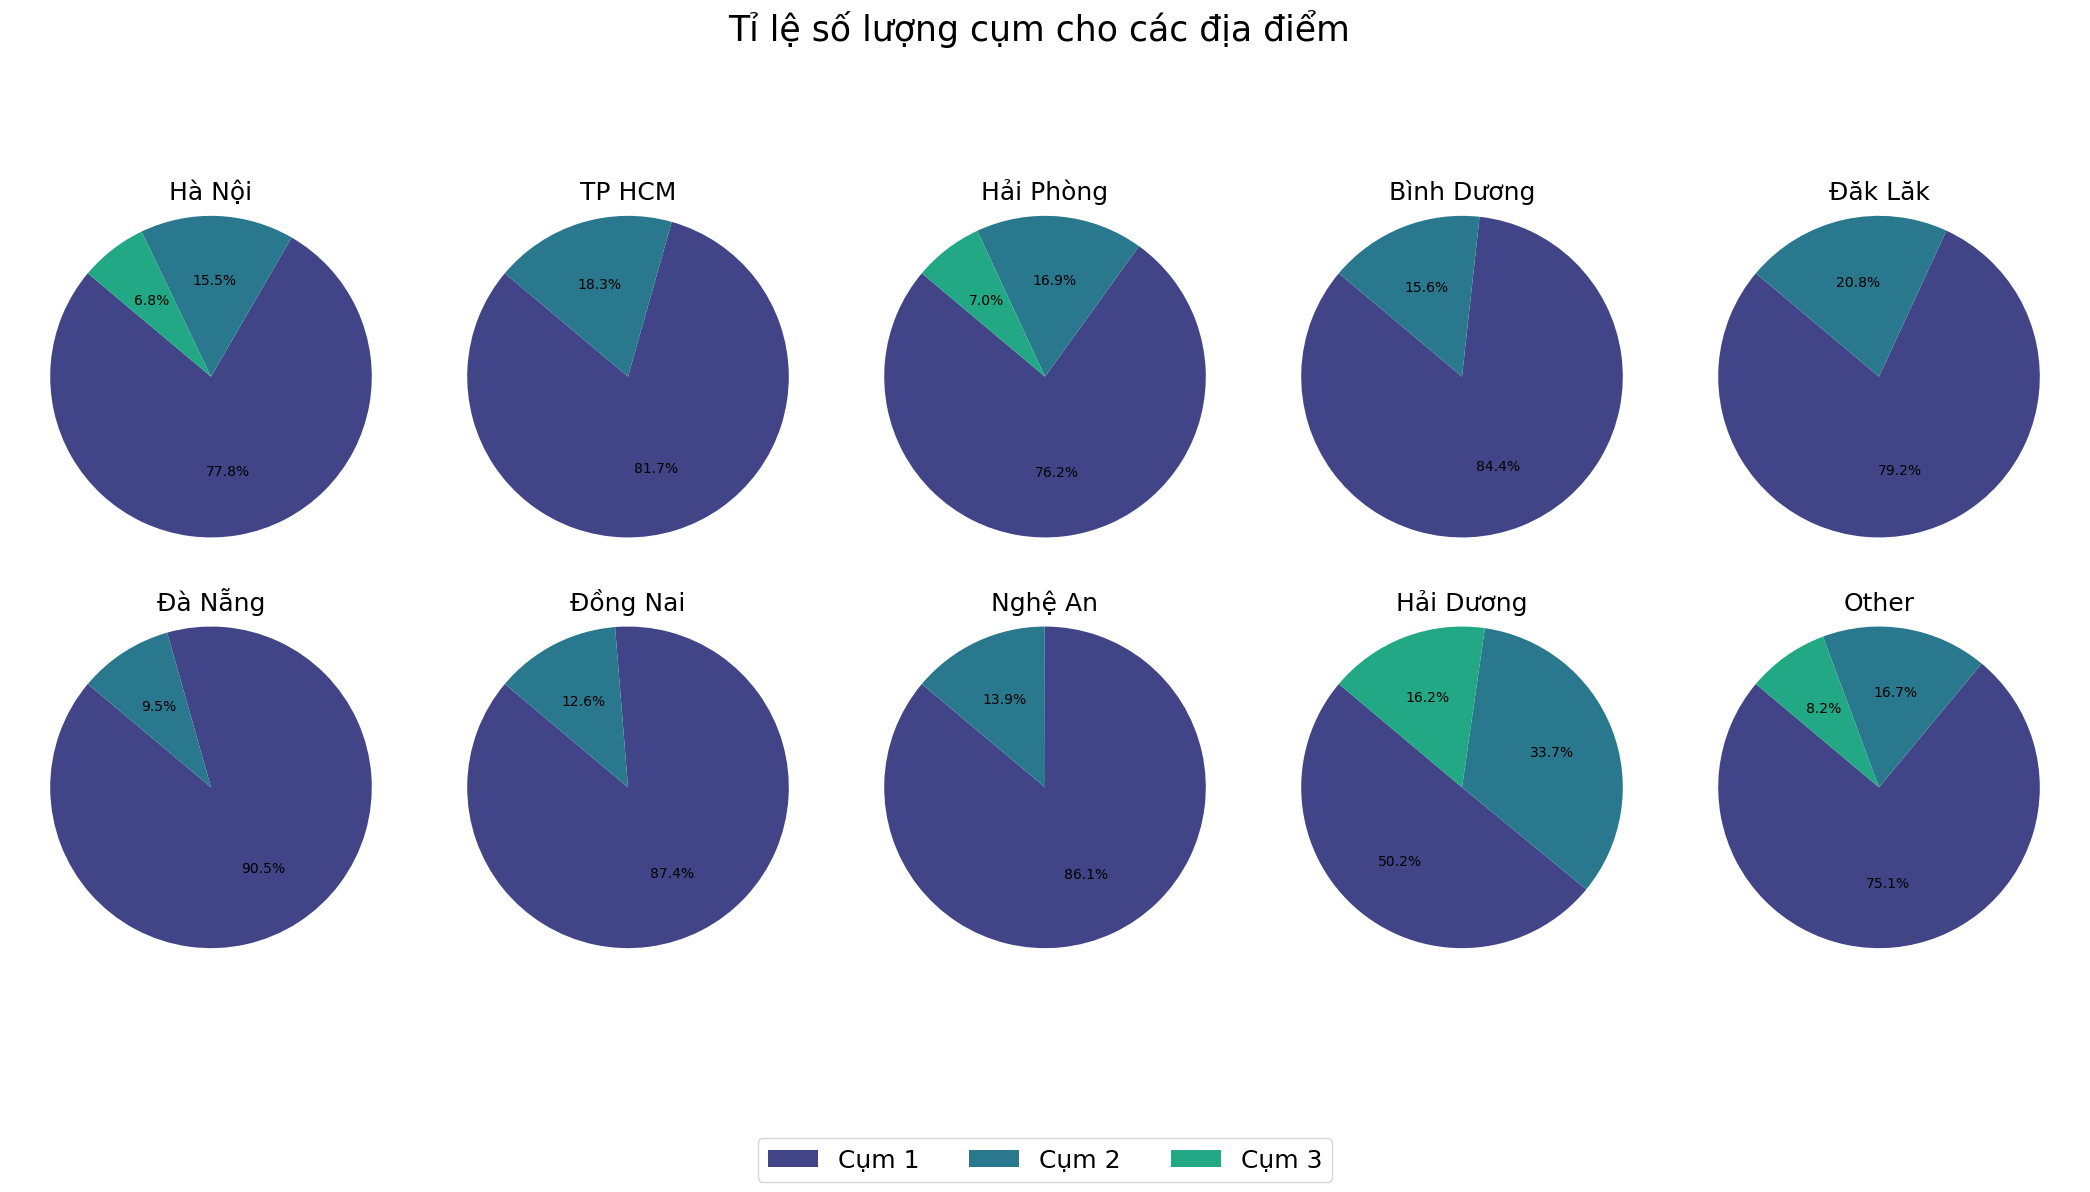

In [ ]:
# Đọc dữ liệu từ file CSV
data_clustered = pd.read_csv('helpper/data_clustered.csv')

# Lấy 9 hãng xe nổi bật nhất
top_brands = data_clustered['Địa điểm'].value_counts().nlargest(9).index

# Tạo một cột mới để gộp các hãng xe còn lại thành nhóm 'Other'
data_clustered['Địa điểm điều chỉnh'] = data_clustered['Địa điểm'].apply(lambda x: x if x in top_brands else 'Other')

# Lọc dữ liệu chỉ chứa 9 hãng xe nổi bật nhất và nhóm 'Other'
adjusted_brands = top_brands.tolist() + ['Other']
top_data_clustered = data_clustered[data_clustered['Địa điểm điều chỉnh'].isin(adjusted_brands)]

# Khởi tạo figure và axes
fig, axes = plt.subplots(2, 5, figsize=(21, 12))

# Màu sắc cho các cụm
colors = sns.color_palette('viridis', len(data_clustered['KMean'].unique()))

# Vẽ biểu đồ tròn cho mỗi hãng xe điều chỉnh
for ax, brand in zip(axes.flatten(), adjusted_brands):
    brand_data = top_data_clustered[top_data_clustered['Địa điểm điều chỉnh'] == brand]
    brand_counts = brand_data['GMM'].value_counts()
    
    # Biểu đồ tròn
    wedges, texts, autotexts = ax.pie(
        brand_counts, 
        labels=None,  # Bỏ chú thích
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors,
       
    )

    ax.set_title(brand, fontsize=18, y=0.92)

# Tạo một legend chung
fig.legend(wedges, [f'Cụm {i + 1}' for i in range(len(colors))], loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5, fontsize='18')

# Đặt tiêu đề chung cho toàn bộ figure
plt.suptitle('Tỉ lệ số lượng cụm cho các địa điểm ', fontsize=25)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Hiển thị biểu đồ
plt.show()

- Tương tự, cụm 1 có tỉ lệ cao nhất trong 3 cụm
- Ở vài thành phố, cụm 2 và 3 khá giống nhau, tuy nhiên có những thành phố không có hoặc ít sự xuất hiện của cụm 3

C:\Users\3\AppData\Local\Temp\ipykernel_17608\1882508573.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data_clustered.groupby(['Km_bins', 'GMM']).size().reset_index(name='Count')


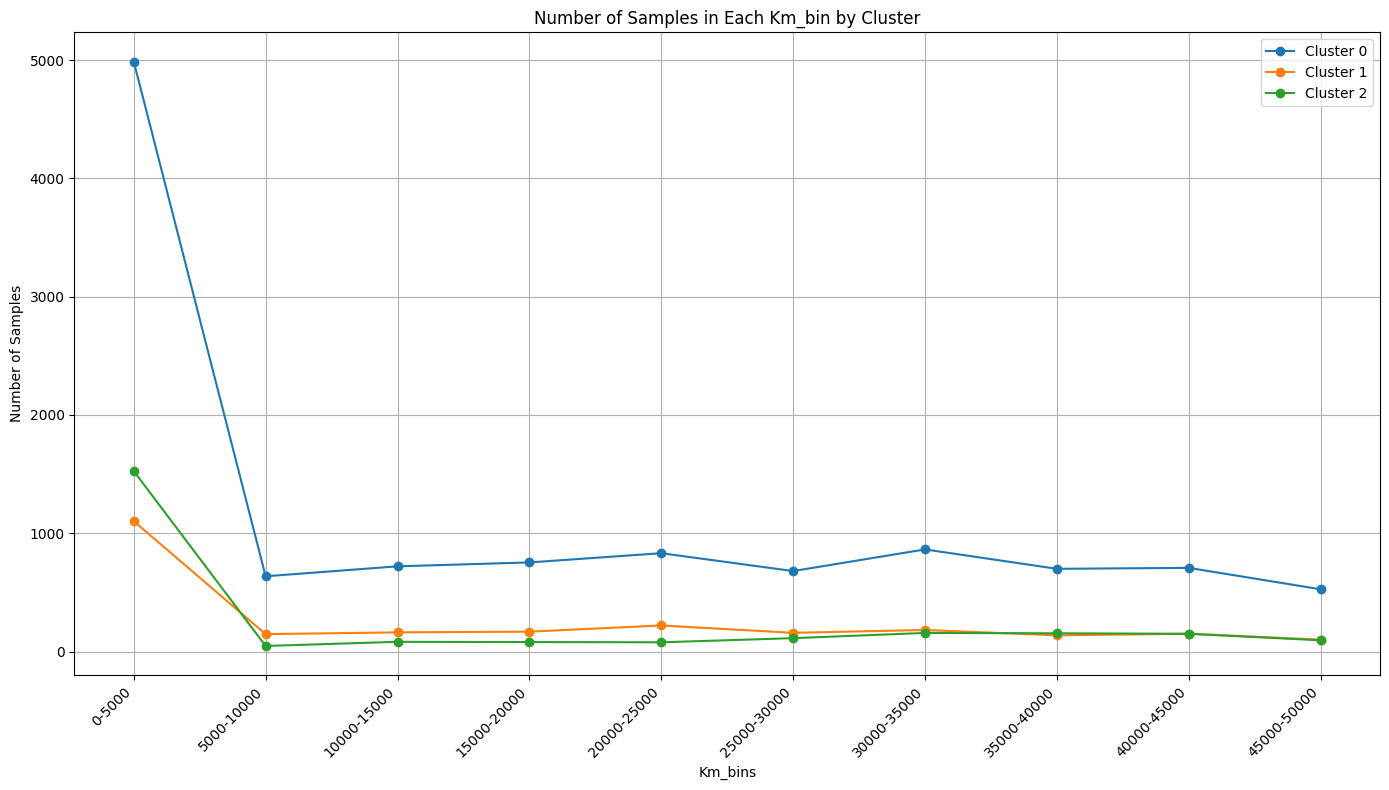

In [90]:
data_clustered = pd.read_csv('helpper/data_gmm.csv')
    
data_clustered['Số Km đã đi'] = data_clustered['Số Km đã đi'].astype(int)

# Chia cột 'Số Km đã đi' thành các khoảng mỗi 50,000 km
max_km = 50000
bins = range(0, max_km + 5000, 5000)
labels = [f'{i}-{i+5000}' for i in bins[:-1]]
data_clustered['Km_bins'] = pd.cut(data_clustered['Số Km đã đi'], bins=bins, labels=labels, right=False)

# Đếm số lượng mẫu trong mỗi khoảng của từng cụm
counts = data_clustered.groupby(['Km_bins', 'GMM']).size().reset_index(name='Count')

# Tạo line plot
plt.figure(figsize=(14, 8))

# Vẽ đường cho từng cụm
for cluster in counts['GMM'].unique():
    cluster_data = counts[counts['GMM'] == cluster]
    plt.plot(cluster_data['Km_bins'], cluster_data['Count'], marker='o', label=f'Cluster {cluster}')

# Đặt tiêu đề và nhãn trục
plt.title('Number of Samples in Each Km_bin by Cluster')
plt.xlabel('Km_bins')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(True)

# Xoay nhãn trục x để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

- Cụm 1 và 3 khá tương đồng nhau
- Cụm 2 có số lượng thấp hơn 2 cụm còn lại tuy nhiên cả 3 cụm nhìn chung đều có sự phân bổ khá đều và tương đồng nhau

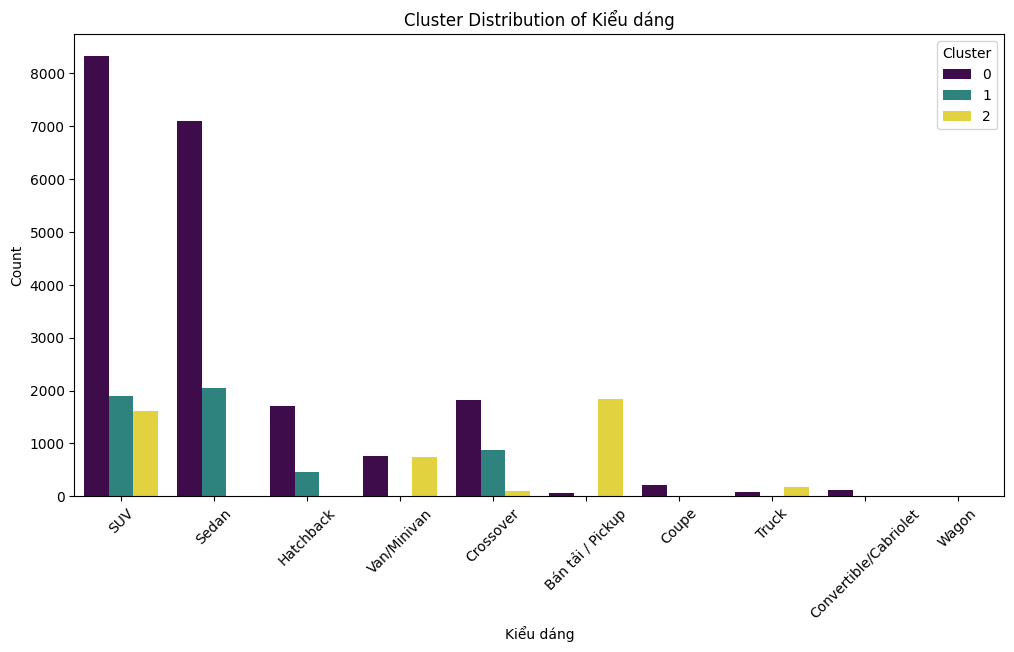

In [92]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Kiểu dáng', hue='GMM', palette='viridis')
plt.title('Cluster Distribution of Kiểu dáng')
plt.xlabel('Kiểu dáng')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster', loc='upper right')
plt.show()


##### Nhận xét:
- Cụm 1 có số lượng lớn ở hầu hết tất cả kiểu dáng đặc biệt ở SUV và Sedan
- Cụm 2 phân bố không đều chủ yếu tập trung ở SUV, Sedan và Crossover
- Cụm 3 tập trung chủ yếu và hầu hết loại Bán tải một phần ở SUV

- Tỉ lệ phân phối cụm theo hãng xe

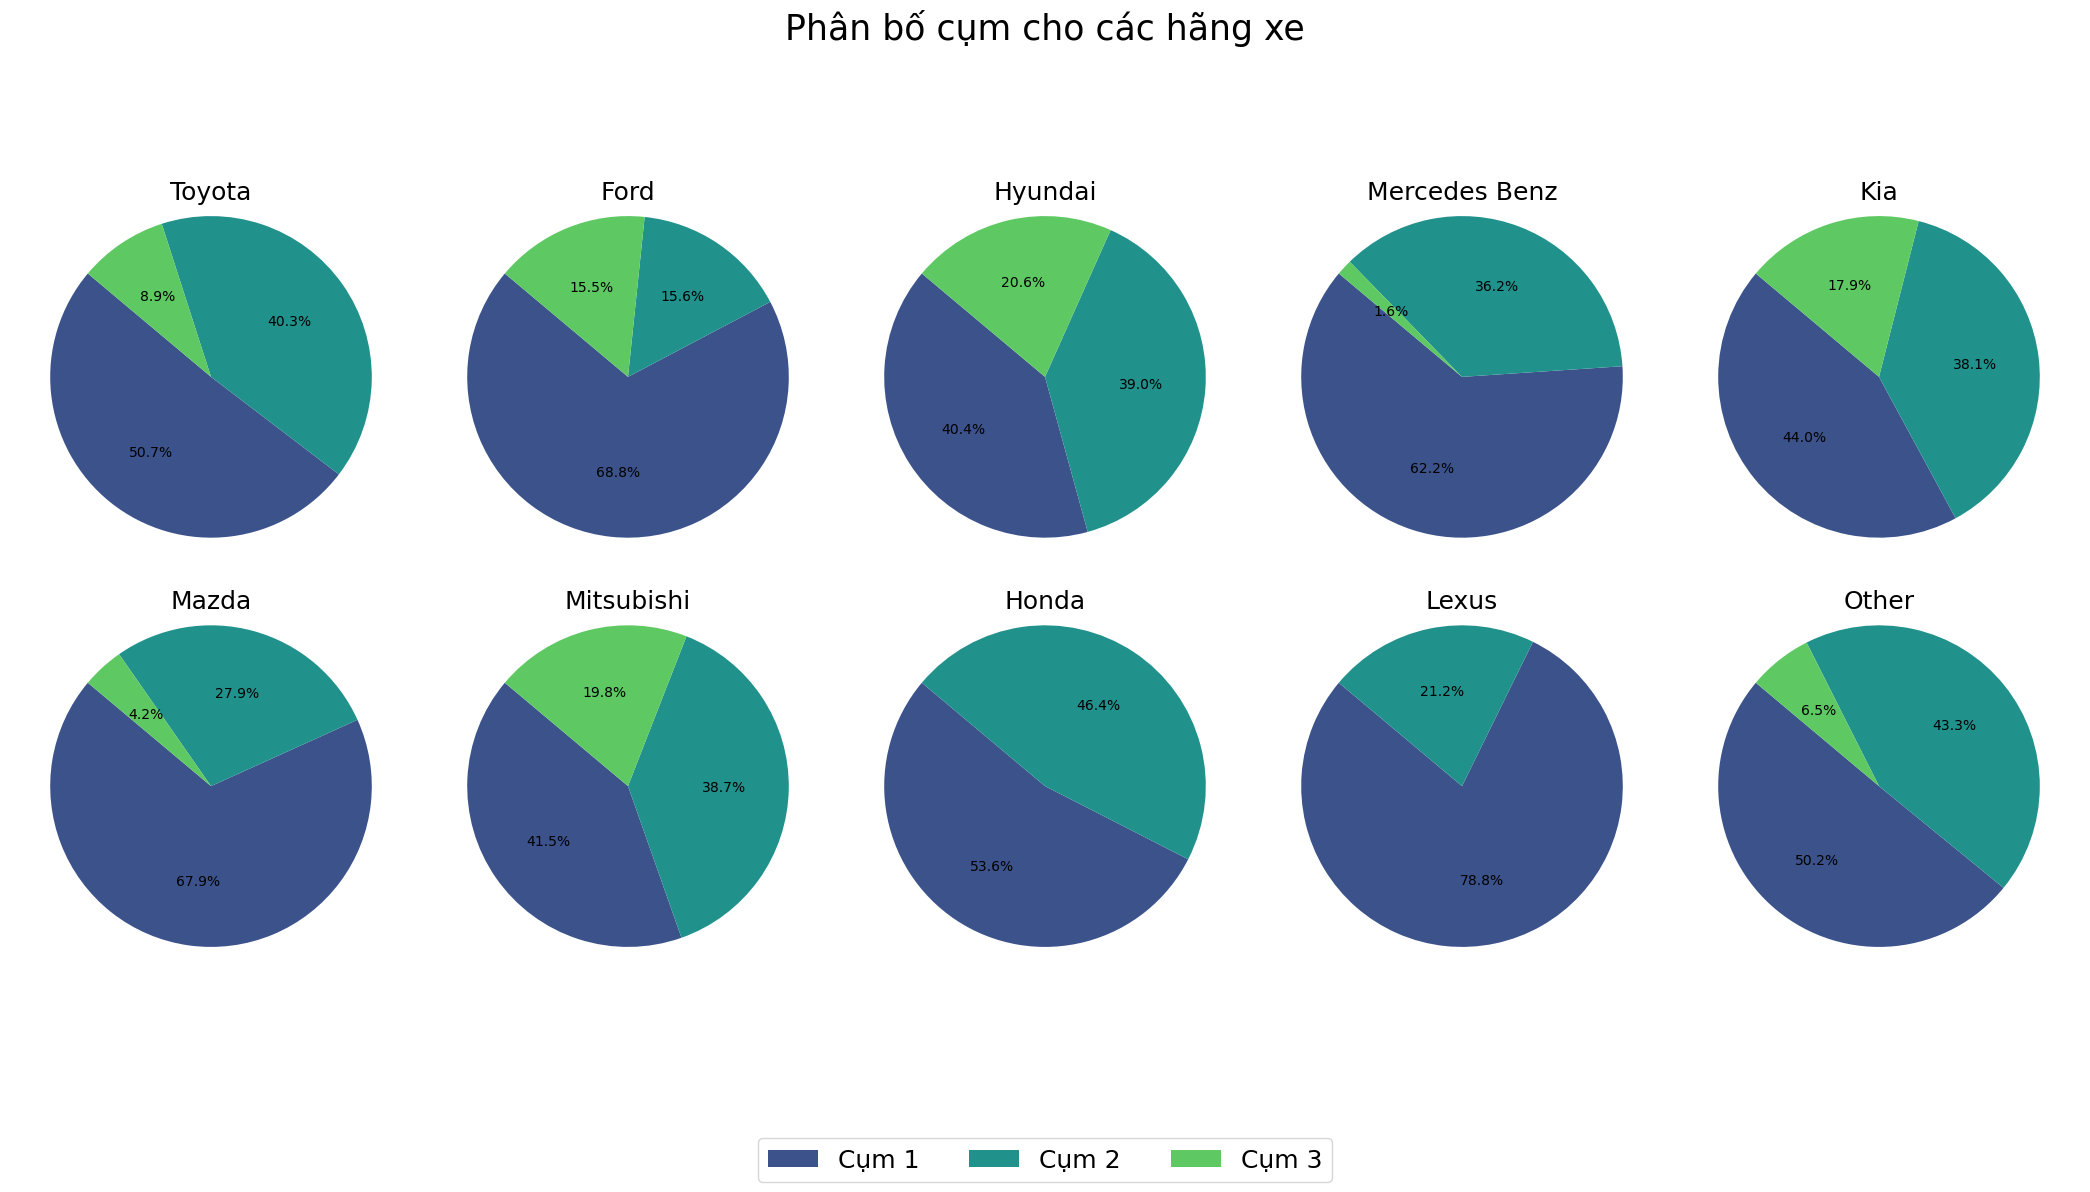

In [ ]:
# Đọc dữ liệu từ file CSV
data_clustered = pd.read_csv('helpper/data_clustered.csv')

# Lấy 9 hãng xe nổi bật nhất
top_brands = data_clustered['Hãng xe'].value_counts().nlargest(9).index

# Tạo một cột mới để gộp các hãng xe còn lại thành nhóm 'Other'
data_clustered['Hãng xe điều chỉnh'] = data_clustered['Hãng xe'].apply(lambda x: x if x in top_brands else 'Other')

# Lọc dữ liệu chỉ chứa 9 hãng xe nổi bật nhất và nhóm 'Other'
adjusted_brands = top_brands.tolist() + ['Other']
top_data_clustered = data_clustered[data_clustered['Hãng xe điều chỉnh'].isin(adjusted_brands)]

# Khởi tạo figure và axes
fig, axes = plt.subplots(2, 5, figsize=(21, 12))

# Màu sắc cho các cụm
colors = sns.color_palette('viridis', len(data_clustered['GMM'].unique()))

# Vẽ biểu đồ tròn cho mỗi hãng xe điều chỉnh
for ax, brand in zip(axes.flatten(), adjusted_brands):
    brand_data = top_data_clustered[top_data_clustered['Hãng xe điều chỉnh'] == brand]
    brand_counts = brand_data['GMM'].value_counts()
    
    # Biểu đồ tròn
    wedges, texts, autotexts = ax.pie(
        brand_counts, 
        labels=None,  # Bỏ chú thích
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors,
       
    )

    ax.set_title(brand, fontsize=18, y=0.92)

# Tạo một legend chung
fig.legend(wedges, [f'Cụm {i + 1}' for i in range(len(colors))], loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5, fontsize='18')

# Đặt tiêu đề chung cho toàn bộ figure
plt.suptitle('Phân bố cụm cho các hãng xe', fontsize=25)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Hiển thị biểu đồ
plt.show()

- Cụm 1 có tỉ lệ số lượng nhiều nhất
- Tiếp đến là cụm 2 và cụm 3 thấp nhất

# So sánh mô hình

`1. Giá`

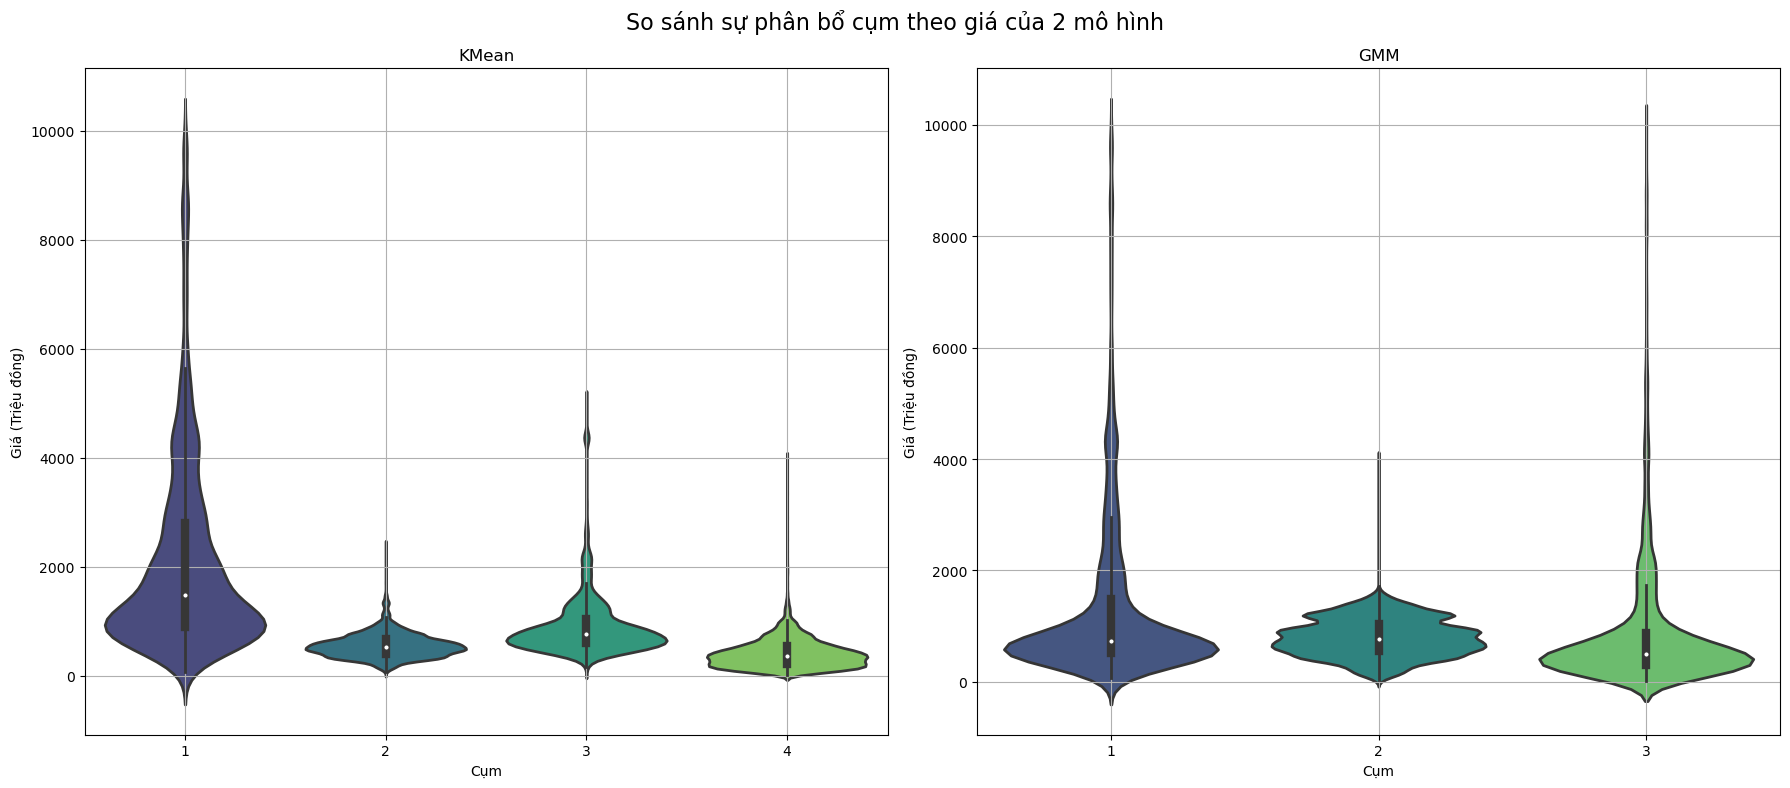

In [ ]:
data_clustered = pd.read_csv('helpper/data_clustered.csv')
data_clustered['KMean_adjusted'] = data_clustered['KMean'] + 1
data_clustered['GMM_adjusted'] = data_clustered['GMM'] + 1

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Vẽ violin plot cho KMean_adjusted
sns.violinplot(data=data_clustered, x='KMean_adjusted', y='Giá', palette='viridis', linewidth=2, width=0.8, scale='width', ax=axes[0])
axes[0].set_title('KMean')
axes[0].set_xlabel('Cụm')
axes[0].set_ylabel('Giá (Triệu đồng)')
axes[0].grid(True)

# Vẽ violin plot cho GMM_adjusted
sns.violinplot(data=data_clustered, x='GMM_adjusted', y='Giá', palette='viridis', linewidth=2, width=0.8, scale='width', ax=axes[1])
axes[1].set_title('GMM')
axes[1].set_xlabel('Cụm')
axes[1].set_ylabel('Giá (Triệu đồng)')
axes[1].grid(True)

fig.suptitle('So sánh sự phân bổ cụm theo giá của 2 mô hình', fontsize=16)

plt.tight_layout()
plt.show()

- Nhìn chung qua, ta cũng có thể thấy sự phân bổ ở K Mean không đều hơn nhiều so với GMM, khi mà ở K Mean số lượng cụm 1 chiếm đáng kể so với 3 cụm còn lại.
- Ở GMM thì phân bổ đều hơn ở 3 cụm

`2. Số Km đã đi`

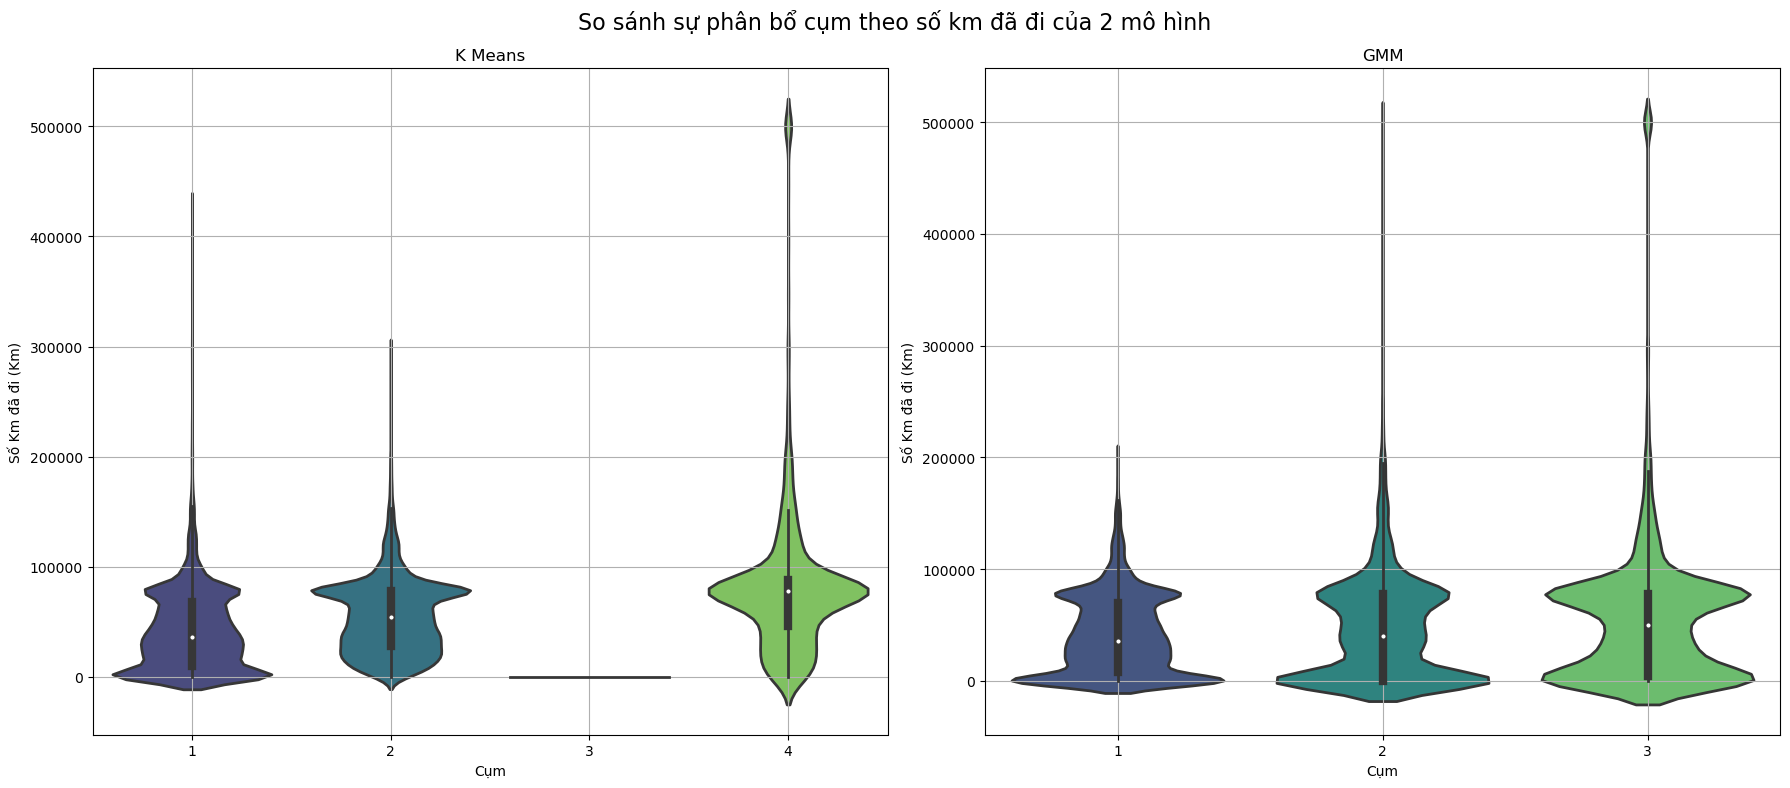

In [ ]:
data_clustered = pd.read_csv('data_clustered.csv')
data_clustered['KMean_adjusted'] = data_clustered['KMean'] + 1
data_clustered['GMM_adjusted'] = data_clustered['GMM'] + 1

# Tạo subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Vẽ violin plot cho KMean_adjusted
sns.violinplot(data=data_clustered, x='KMean_adjusted', y='Số Km đã đi', palette='viridis', linewidth=2, width=0.8, scale='width', ax=axes[0])
axes[0].set_title('K Means')
axes[0].set_xlabel('Cụm')
axes[0].set_ylabel('Số Km đã đi (Km)')
axes[0].grid(True)

# Vẽ violin plot cho GMM_adjusted
sns.violinplot(data=data_clustered, x='GMM_adjusted', y='Số Km đã đi', palette='viridis', linewidth=2, width=0.8, scale='width', ax=axes[1])
axes[1].set_title('GMM')
axes[1].set_xlabel('Cụm')
axes[1].set_ylabel('Số Km đã đi (Km)')
axes[1].grid(True)

fig.suptitle('So sánh sự phân bổ cụm theo số km đã đi của 2 mô hình', fontsize=16)
# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

- K Mean phân bổ không đều rất nhiều so với GMM
- Ở K mean, cụm 1 2 3 tập trung chủ yếu ở vùng 10 000 Km, tuy nhiên cụm 3 chỉ tập trung duy nhất ở 0 Km
- Ở GMM thì đều hơn, khi mà cụm 1 cụm 2 gần như giống nhau và cả 3 cụm phân bổ chủ yếu ở 10 000Km

Thống kế theo năm sản xuất

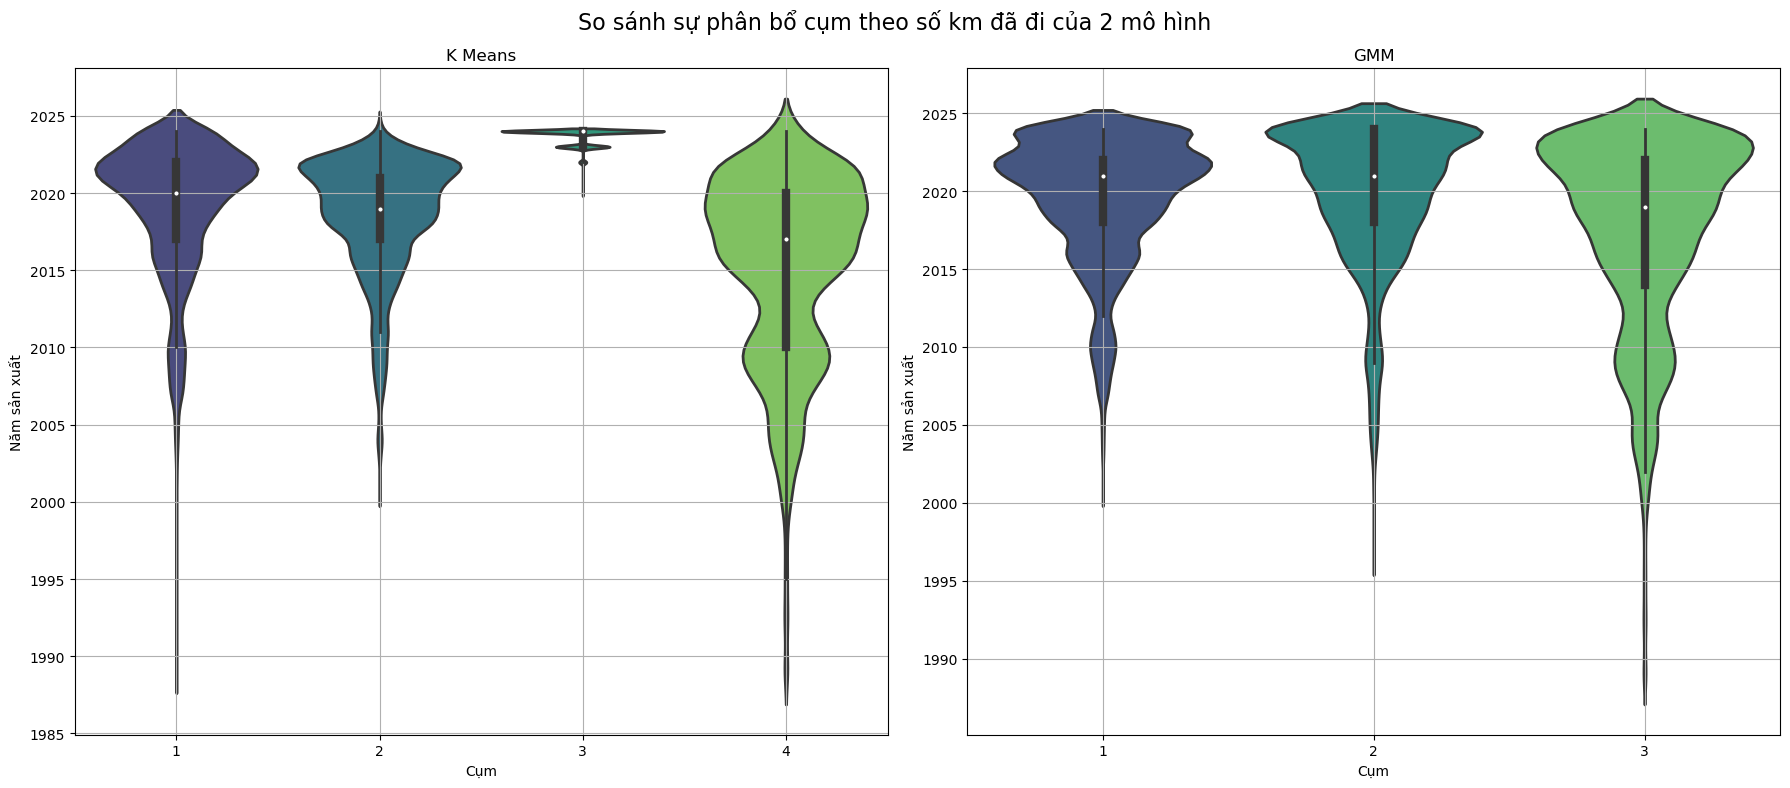

In [ ]:
data_clustered = pd.read_csv('data_clustered.csv')
data_clustered['KMean_adjusted'] = data_clustered['KMean'] + 1
data_clustered['GMM_adjusted'] = data_clustered['GMM'] + 1

# Tạo subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Vẽ violin plot cho KMean_adjusted
sns.violinplot(data=data_clustered, x='KMean_adjusted', y='Năm sản xuất', palette='viridis', linewidth=2, width=0.8, scale='width', ax=axes[0])
axes[0].set_title('K Means')
axes[0].set_xlabel('Cụm')
axes[0].set_ylabel('Năm sản xuất')
axes[0].grid(True)

# Vẽ violin plot cho GMM_adjusted
sns.violinplot(data=data_clustered, x='GMM_adjusted', y='Năm sản xuất', palette='viridis', linewidth=2, width=0.8, scale='width', ax=axes[1])
axes[1].set_title('GMM')
axes[1].set_xlabel('Cụm')
axes[1].set_ylabel('Năm sản xuất')
axes[1].grid(True)

fig.suptitle('So sánh sự phân bổ cụm theo năm sản xuất của 2 mô hình', fontsize=16)
# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

- K Mean có cụm 1 2 4 tương đối giống nhau, khi mà tập trung ở 2024 đến 2015 là nhiều, nhưng cụm 3 chỉ tập trung ở 2024 và 2022 chủ yếu
- GMM có sự phân bổ đều hơn và tốt hơn

`4. Một vài đặc trưng khác`

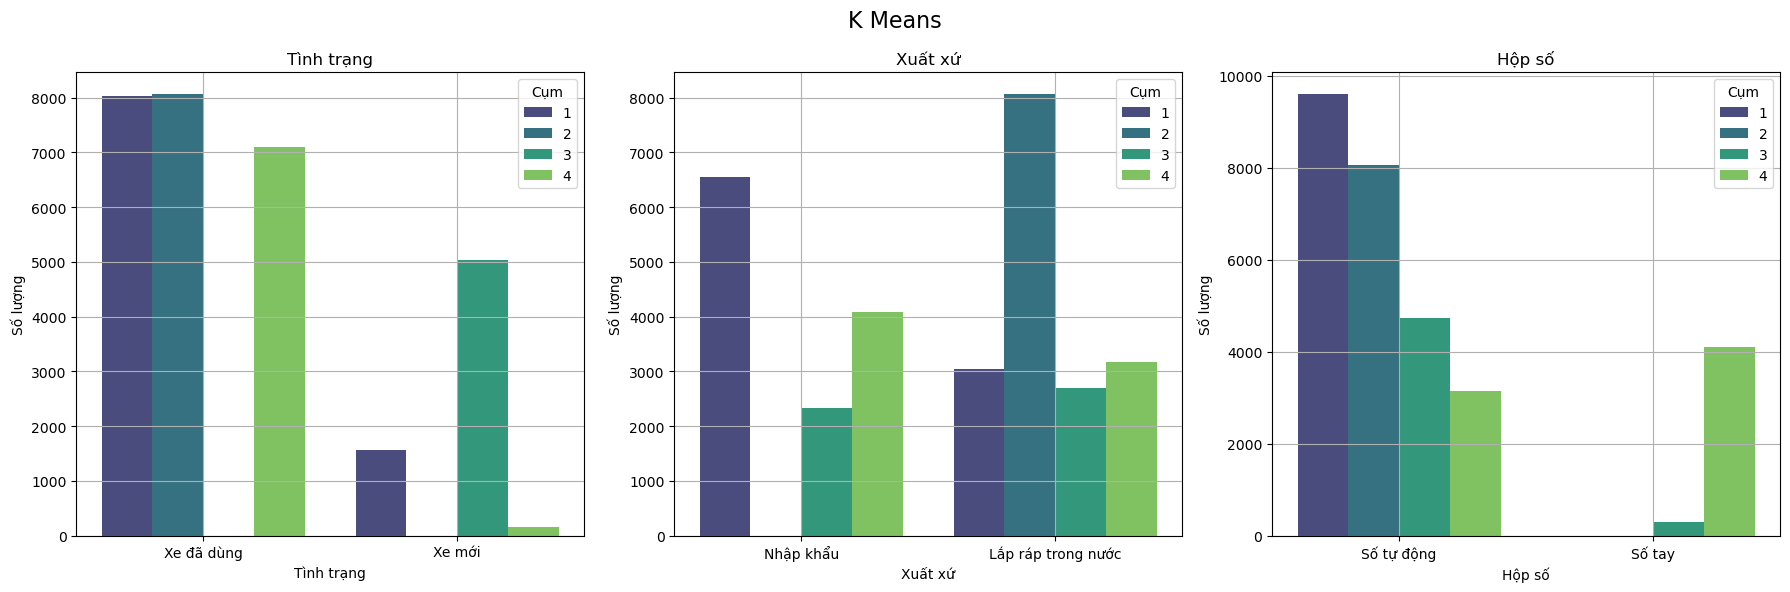

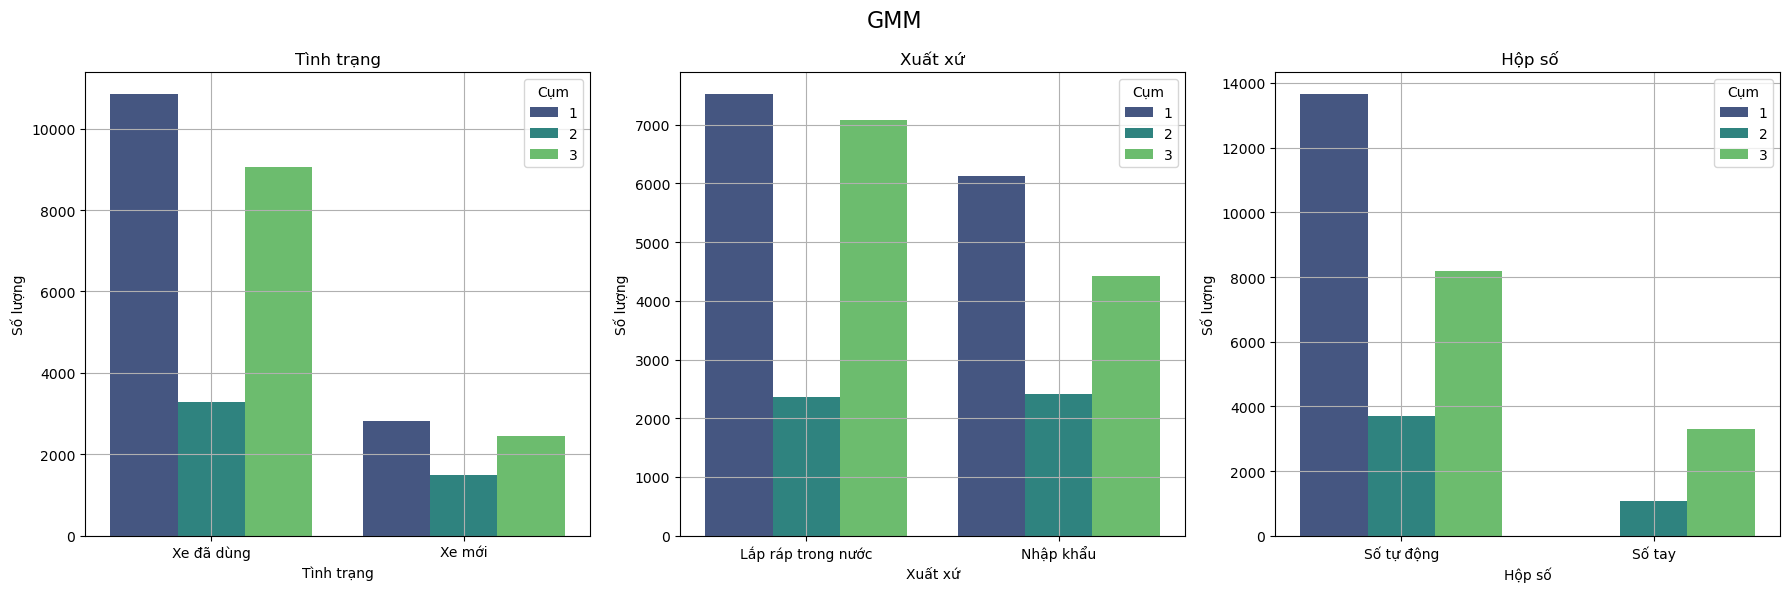

In [ ]:
data = pd.read_csv('data_clustered.csv')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot cho đặc trưng 'Tình trạng' (kiểu nhị phân)
# Sắp xếp lại dữ liệu dựa trên cột KMean
data.sort_values(by='KMean', inplace=True)

# Chuyển đổi kiểu dữ liệu của cột KMean thành chuỗi
data['KMean'] = data['KMean'].astype(str)
data['Cụm'] = data['KMean'].replace({'0': '1', '1': '2', '2': '3', '3': '4'})
sns.countplot(ax=axes[0],  hue='Cụm', x='Tình trạng', data=data, palette='viridis')
axes[0].set_title('Tình trạng')
axes[0].set_xlabel('Tình trạng')
axes[0].set_ylabel('Số lượng')
axes[0].grid(True)

# Plot cho đặc trưng 'Xuất xứ' (kiểu nhị phân)  
sns.countplot(ax=axes[1], x='Xuất xứ', hue='Cụm', data=data, palette='viridis')
axes[1].set_title('Xuất xứ')
axes[1].set_xlabel('Xuất xứ')
axes[1].set_ylabel('Số lượng')
axes[1].grid(True)

# Plot cho đặc trưng 'Hộp số' (kiểu nhị phân)
sns.countplot(ax=axes[2], x='Hộp số', hue='Cụm', data=data, palette='viridis')
axes[2].set_title('Hộp số')
axes[2].set_xlabel('Hộp số')
axes[2].set_ylabel('Số lượng')
axes[2].grid(True)


fig.suptitle('K Means', fontsize=16)

# Tăng khoảng cách giữa các subplot
plt.tight_layout()

# Hiển thị hình
plt.show()

data = pd.read_csv('data_clustered.csv')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot cho đặc trưng 'Tình trạng' (kiểu nhị phân)
# Sắp xếp lại dữ liệu dựa trên cột KMean
data.sort_values(by='GMM', inplace=True)

# Chuyển đổi kiểu dữ liệu của cột KMean thành chuỗi
data['GMM'] = data['GMM'].astype(str)
data['Cụm'] = data['GMM'].replace({'0': '1', '1': '2', '2': '3', '3': '4'})
sns.countplot(ax=axes[0],  hue='Cụm', x='Tình trạng', data=data, palette='viridis')
axes[0].set_title('Tình trạng')
axes[0].set_xlabel('Tình trạng')
axes[0].set_ylabel('Số lượng')
axes[0].grid(True)

# Plot cho đặc trưng 'Xuất xứ' (kiểu nhị phân)  
sns.countplot(ax=axes[1], x='Xuất xứ', hue='Cụm', data=data, palette='viridis')
axes[1].set_title('Xuất xứ')
axes[1].set_xlabel('Xuất xứ')
axes[1].set_ylabel('Số lượng')
axes[1].grid(True)

# Plot cho đặc trưng 'Hộp số' (kiểu nhị phân)
sns.countplot(ax=axes[2], x='Hộp số', hue='Cụm', data=data, palette='viridis')
axes[2].set_title(' Hộp số')
axes[2].set_xlabel('Hộp số')
axes[2].set_ylabel('Số lượng')
axes[2].grid(True)

fig.suptitle('GMM', fontsize=16)


# Tăng khoảng cách giữa các subplot
plt.tight_layout()

# Hiển thị hình
plt.show()

- Về tình trạng, ở 2 mô hình đều phân bổ không đều, các cụm thường tập trung ở xe đã dùng nhiều hơn
- Về xuất xứ, GMM phân bổ tốt hơn khi mà ở lắp ráp trong nước và nhập khẩu có số lượng đều nhau, còn K Means thì không đều
- Ở Hộp số, cả 2 mô hình đều không đều, chủ yếu tập trung ở số tự động

# Kết luận:
##### 1. Mô hình GMM cho thấy ưu điểm, tốt hơn mô hình K-means. Có thể nhận diện và phân cụm rõ ràng ưu việt hơn.
##### 2. Đối với mô hình GMM dữ liệu phân chia thành 3 cụm là hợp lý nhất, cụ thể
+ Đa số các đặc trưng GMM phân cụm đồng đều và hợp lí, tuy nhiên vẫn có những đặc trưng mô hình phân bổ không đều như tình trạng, hộp số, ...
##### 3. Đối với mô hình K-means dữ liệu được phân chia thành 4 cụm là tối ưu nhất cụ thể như sau: 
+ Đa số các đặc trưng mô hình dự đoán không đồng đều đáng kể, nhất là các đặc trưng như giá, số Km đã đi, năm sản xuất, ...
##### 4. Những đặc trưng như Giá, Tình trạng, Hộp số cả 2 mô hình đều dự đoán không đồng đều